Branin synthetic function:

GP CBM versus GP dCBM (winner)

https://www.sfu.ca/~ssurjano/branin.html

In [1]:
pip install pyGPGO


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 11.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of arviz to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 2

In [2]:
!pip install -q latextable


In [3]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc
rc('text', usetex=False)

from tabulate import tabulate
from texttable import Texttable

import latextable

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
### Inputs:

obj_func = 'Branin'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util = 'CBM'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [5]:
### Objective function:

if obj_func == 'Branin':

    # True y bounds:
    operator = -1
    y_lb = 0.397887 # targets global minimum
    y_global_orig = y_lb * operator # targets global minimum

# Constraints:
    lb_x1 = -5
    ub_x1 = +10
    lb_x2 = +0
    ub_x2 = +15

# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb_x1, ub_x1]),
             'x2_training': ('cont', [lb_x2, ub_x2])}

# Test data:
    x1_test = np.linspace(lb_x1, ub_x1, n_test)
    x2_test = np.linspace(lb_x2, ub_x2, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training, a = 1, b = (5.1 / (4 * (np.pi) ** 2)), c = (5 / (np.pi)), r = 6, s = 10, t = (1 / (8 * np.pi))):
        return operator * ((a * (x2_training - b * x1_training ** 2 + c * x1_training - r) ** 2) +
                 s * (1 - t) * np.cos(x1_training) + s)


In [6]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [7]:
### Cumulative Regret Calculator:

def min_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [8]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [9]:
### Surrogate derivatives:

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)

def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE

    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T

        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)

        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.diag(np.dot(dKstar, alpha_Kstar))

        return dm, ds


In [10]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):
    def __init__(self, mode, eps=eps, **params):

        self.params = params
        self.eps = eps

        mode_dict = {
            'CBM': self.CBM
        }

        self.f = mode_dict[mode]

    def CBM(self, y_global_orig, mean, std, ds, dm):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        f = (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
        df = dsdx * (gamma + np.sqrt(Beta_CBM)) + (std + self.eps) * dmdx
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()

    def d_eval(self, tau, mean, std, ds, dm):

        return self.f(tau, mean, std, ds, dm, **self.params)


In [11]:
n_start_AcqFunc = 20
inverse = -1
n_start = n_start_AcqFunc

maxfunMinimize = 50 * dim # allows for both function and gradient evaluation capping, using the problem's input dimensions


In [12]:
## GPGO_approx: BayesOpt class, acquision function optimised using approximate acquisition function gradients

class GPGO_approx(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval \t Proposed input x           \t Output y \t Best y \t nfev \t CBM exact \t CBM approx \t Ratio \t Euclid '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3} \t {:3} \t {:3} \t {:3} \t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):

        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        nfev = np.array([res.nfev for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.nfev = np.round(np.mean(nfev), 1)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.max_acqfuncApprox = -min(self.f_best) + eps
        self.history.append(self.max_acqfuncApprox)

        opt2 = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)

        x_best2 = np.array([res2.x for res2 in opt2])
        f_best2 = np.array([np.atleast_1d(res2.fun)[0] for res2 in opt2])
        self.x_best2 = x_best2
        self.f_best2 = f_best2
        self.best2 = x_best2[np.argmin(f_best2)]
        self.max_acqfuncExact = -min(self.f_best2) + eps
        self.history.append(self.max_acqfuncExact)
        self.history.append(self.nfev)

        self.euclid = np.sqrt(np.sum((self.x_best - self.start_points_arr)**2))
        self.history.append(self.euclid)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * np.round(self.GP.y[init_eval], 8), inverse * np.round(self.tau, 8), '', '', '', '', ''))

    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * np.round(self.GP.y[-1], 8))
        curr_best = str(inverse * np.round(self.tau, 8))
        f_gEvals = str(self.nfev)
        max_acqfuncExact = np.round(self.max_acqfuncExact, 8)
        max_acqfuncApprox = np.round(self.max_acqfuncApprox, 8)
        ratio = np.round(max_acqfuncExact/max_acqfuncApprox, 3)
        euclid = np.round(self.euclid, 3)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            f_gEvals = BOLD + OKGREEN + f_gEvals + ENDC
            max_acqfuncExact = BOLD + OKGREEN + str(max_acqfuncExact) + ENDC
            max_acqfuncApprox = BOLD + OKGREEN + str(max_acqfuncApprox) + ENDC
            ratio = BOLD + OKGREEN + str(ratio) + ENDC
            euclid = BOLD + OKGREEN + str(euclid) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_gEvals, max_acqfuncExact, max_acqfuncApprox, ratio, euclid))

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [13]:
## GPGO_exact: BayesOpt class, acquision function optimised using exact acquisition function gradients

class GPGO_exact(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval \t Proposed input x           \t Output y \t Best y \t nfev \t CBM exact \t CBM approx \t Ratio \t Euclid '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3} \t {:3} \t {:3} \t {:3} \t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):

        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        nfev = np.array([res.nfev for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.nfev = np.round(np.mean(nfev), 1)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.max_acqfuncExact = -min(self.f_best) + eps
        self.history.append(self.max_acqfuncExact)

        opt2 = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)

        x_best2 = np.array([res2.x for res2 in opt2])
        f_best2 = np.array([np.atleast_1d(res2.fun)[0] for res2 in opt2])
        self.x_best2 = x_best2
        self.f_best2 = f_best2
        self.best2 = x_best2[np.argmin(f_best2)]
        self.max_acqfuncApprox = -min(self.f_best2) + eps
        self.history.append(self.max_acqfuncApprox)
        self.history.append(self.nfev)

        self.euclid = np.sqrt(np.sum((self.x_best - self.start_points_arr)**2))
        self.history.append(self.euclid)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * np.round(self.GP.y[init_eval], 8), inverse * np.round(self.tau, 8), '', '', '', '', ''))

    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)

        curr_eval = str(inverse * np.round(self.GP.y[-1], 8))
        curr_best = str(inverse * np.round(self.tau, 8))
        f_gEvals = str(self.nfev)
        max_acqfuncExact = np.round(self.max_acqfuncExact, 8)
        max_acqfuncApprox = np.round(self.max_acqfuncApprox, 8)
        ratio = np.round(max_acqfuncExact/max_acqfuncApprox, 3)
        euclid = np.round(self.euclid, 3)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            f_gEvals = BOLD + OKGREEN + f_gEvals + ENDC
            max_acqfuncExact = BOLD + OKGREEN + str(max_acqfuncExact) + ENDC
            max_acqfuncApprox = BOLD + OKGREEN + str(max_acqfuncApprox) + ENDC
            ratio = BOLD + OKGREEN + str(ratio) + ENDC
            euclid = BOLD + OKGREEN + str(euclid) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_gEvals, max_acqfuncExact, max_acqfuncApprox, ratio, euclid))

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [14]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_1 = GPGO_approx(surrogate_approx_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 1.25533007 10.8048674 ]	 56.52874005	 27.6816669	     	     	     	     	    
init	 [-4.99828438  4.53498859]	 172.66531087	 27.6816669	     	     	     	     	    
init	 [-2.79866164  1.38507892]	 102.58290349	 27.6816669	     	     	     	     	    
init	 [-2.20609683  5.18341091]	 28.8680646	 27.6816669	     	     	     	     	    
init	 [0.95151211 8.08225101]	 27.6816669	 27.6816669	     	     	     	     	    
1	 [8.41909995 1.27566317]	 5.08993488	 5.08993488	 19.2 	 30.51009404 	 30.51009404 	 1.0 	 16.317
2  	 [10. 15.]	 145.87219088	 5.08993488	 20.2 	 7.91836202 	 7.91836202 	 1.0 	 21.31
3  	 [7.42985933 8.64585641]	 67.81968628	 5.08993488	 27.4 	 7.91836197 	 7.91836199 	 1.0 	 22.149
4  	 [-4.67712792 14.21955317]	 13.86524479	 5.08993488	 34.8 	 7.91836202 	 7.91836202 	 1.0 	 35.492
5  	 [2.92170062 0.        ]	 6.64498705	 5.08993488	 33.2 	 7.91836053 	 7.9

In [15]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_2 = GPGO_approx(surrogate_approx_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [1.53992353 0.38889348]	 22.31361309	 6.69205151	     	     	     	     	    
init	 [3.24493717 6.52983589]	 19.23310997	 6.69205151	     	     	     	     	    
init	 [1.30551703 4.95502232]	 13.17785156	 6.69205151	     	     	     	     	    
init	 [-1.93027049  9.2890645 ]	 6.69205151	 6.69205151	     	     	     	     	    
init	 [-0.50517989  4.00240913]	 26.43752276	 6.69205151	     	     	     	     	    
1  	 [ 9.5587047  12.00387527]	 89.09951357	 6.69205151	 28.2 	 9.52047865 	 9.52047865 	 1.0 	 15.704
2	 [9.59366035 1.69164323]	 1.39845934	 1.39845934	 30.3 	 9.52047865 	 9.52047865 	 1.0 	 23.617
3  	 [ 3.24245232 12.67669673]	 110.25694223	 1.39845934	 37.4 	 4.22688633 	 4.22688633 	 1.0 	 12.226
4  	 [-5. 15.]	 17.50829952	 1.39845934	 41.1 	 4.2268863 	 4.22688648 	 1.0 	 35.205
5  	 [-5.          0.62248225]	 287.11892733	 1.39845934	 32.0 	 4.2268863 	 4.226

In [16]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_3 = GPGO_approx(surrogate_approx_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 3.26196854 10.62221734]	 71.68783452	 18.07886746	     	     	     	     	    
init	 [-0.63642892  7.66241408]	 18.07886746	 18.07886746	     	     	     	     	    
init	 [ 8.39420432 13.44439633]	 141.9865353	 18.07886746	     	     	     	     	    
init	 [-3.11622034  3.10864317]	 83.31045707	 18.07886746	     	     	     	     	    
init	 [-4.22799195  6.61214765]	 76.52941707	 18.07886746	     	     	     	     	    
1  	 [6.70472147 4.59545299]	 30.72679181	 18.07886746	 8.2 	 20.90729461 	 20.90729461 	 1.0 	 17.285
2	 [-5. 15.]	 17.50829952	 17.50829952	 31.8 	 20.9072946 	 20.90729461 	 1.0 	 34.798
3  	 [1.87813003 0.        ]	 19.11211967	 17.50829952	 40.5 	 20.33669062 	 20.33672538 	 1.0 	 32.192
4	 [10.  0.]	 10.96088904	 10.96088904	 40.2 	 20.33662279 	 20.33672491 	 1.0 	 24.982
5  	 [ 0.18019564 15.        ]	 105.61322238	 10.96088904	 38.2 	 13.78889358 	

In [17]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number =  4

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_4 = GPGO_approx(surrogate_approx_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [9.50544759 8.20848374]	 32.51676745	 7.24712687	     	     	     	     	    
init	 [ 9.5902654  10.72223991]	 66.20566674	 7.24712687	     	     	     	     	    
init	 [5.46593237 3.24134243]	 20.90089402	 7.24712687	     	     	     	     	    
init	 [9.64411682 0.09345383]	 7.24712687	 7.24712687	     	     	     	     	    
init	 [-1.20526456  6.52187299]	 15.94137698	 7.24712687	     	     	     	     	    
1  	 [ 1.25164457 13.57001383]	 100.61648848	 7.24712687	 23.4 	 10.07555401 	 10.07555401 	 1.0 	 15.464
2  	 [-5.  0.]	 308.12909601	 7.24712687	 31.4 	 10.07555401 	 10.07555401 	 1.0 	 26.074
3  	 [-5. 15.]	 17.50829952	 7.24712687	 35.8 	 10.07554914 	 10.07555395 	 1.0 	 23.424
4  	 [1.02550188 0.        ]	 35.26382462	 7.24712687	 41.4 	 10.07536463 	 10.07554914 	 1.0 	 18.119
5  	 [3.9307135  8.53163599]	 49.36135922	 7.24712687	 38.0 	 10.07551426 	 10.075542

In [18]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_5 = GPGO_approx(surrogate_approx_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-1.67010243 13.06098459]	 25.39069055	 25.31130919	     	     	     	     	    
init	 [-1.89921267 13.77916362]	 25.31130919	 25.31130919	     	     	     	     	    
init	 [2.32616783 9.17615794]	 41.60147975	 25.31130919	     	     	     	     	    
init	 [6.48861785 7.77626982]	 63.81281922	 25.31130919	     	     	     	     	    
init	 [-0.54799248  2.81581843]	 34.96620364	 25.31130919	     	     	     	     	    
1	 [8.84124421 0.03321319]	 5.96108856	 5.96108856	 22.5 	 28.13973633 	 28.13973633 	 1.0 	 15.513
2  	 [10. 15.]	 145.87219088	 5.96108856	 33.8 	 8.78951571 	 8.78951571 	 1.0 	 17.541
3  	 [-5.          6.70213185]	 122.66376316	 5.96108856	 34.0 	 8.78951489 	 8.78951525 	 1.0 	 23.185
4  	 [ 3.78078175 15.        ]	 175.76081247	 5.96108856	 35.8 	 8.78951418 	 8.78951418 	 1.0 	 16.682
5  	 [-5.  0.]	 308.12909601	 5.96108856	 34.6 	 8.78949922 	 8.78949

In [19]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_6 = GPGO_approx(surrogate_approx_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [8.39290227 4.97969708]	 15.55386064	 15.31731051	     	     	     	     	    
init	 [7.31843685 0.62544939]	 15.31731051	 15.31731051	     	     	     	     	    
init	 [-3.3851498   8.92578096]	 16.22228892	 15.31731051	     	     	     	     	    
init	 [2.94726043 6.28211143]	 15.40637358	 15.31731051	     	     	     	     	    
init	 [0.03111774 9.33779148]	 31.07053246	 15.31731051	     	     	     	     	    
1  	 [ 9.64829531 12.55362889]	 98.32295674	 15.31731051	 24.8 	 18.14573766 	 18.14573766 	 1.0 	 14.535
2  	 [-5.  0.]	 308.12909601	 15.31731051	 36.9 	 18.14573766 	 18.14573766 	 1.0 	 27.225
3  	 [ 4.34724927 14.59608757]	 177.48889453	 15.31731051	 15.6 	 18.14573766 	 18.14573766 	 1.0 	 2.696
4	 [-2.66752759 14.5735353 ]	 13.0766899	 13.0766899	 40.5 	 18.14573642 	 18.14573646 	 1.0 	 11.543
5  	 [1.70945029 0.2487047 ]	 20.28821545	 13.0766899	 39.9 	 15

In [20]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_7 = GPGO_approx(surrogate_approx_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_7.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-3.85537566 11.69878188]	 8.29931785	 5.21133532	     	     	     	     	    
init	 [ 1.57613847 10.85197767]	 59.50408381	 5.21133532	     	     	     	     	    
init	 [9.66984268 8.07743806]	 29.71492141	 5.21133532	     	     	     	     	    
init	 [2.51680695 1.080767  ]	 5.21133532	 5.21133532	     	     	     	     	    
init	 [-0.9734153   7.49823751]	 15.4310572	 5.21133532	     	     	     	     	    
1  	 [-4.97859679  1.38393519]	 260.32939528	 5.21133532	 20.4 	 8.03976247 	 8.03976247 	 1.0 	 16.065
2  	 [ 8.71931969 15.        ]	 173.14310053	 5.21133532	 31.8 	 8.03976247 	 8.03976247 	 1.0 	 14.833
3  	 [10.  0.]	 10.96088904	 5.21133532	 34.6 	 8.0397621 	 8.03976247 	 1.0 	 30.068
4  	 [-3.39684884  5.54228873]	 54.79871094	 5.21133532	 3.2 	 8.03976247 	 8.03976247 	 1.0 	 13.179
5  	 [4.54949343 5.86823092]	 28.11312528	 5.21133532	 34.6 	 8.03974702 	 8.

In [21]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_8 = GPGO_approx(surrogate_approx_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 8.10144104 14.52810994]	 175.17297136	 15.41624547	     	     	     	     	    
init	 [8.0379181  7.96283537]	 49.321738	 15.41624547	     	     	     	     	    
init	 [-1.50907508  0.17098206]	 83.26753462	 15.41624547	     	     	     	     	    
init	 [1.45703227 6.0352704 ]	 15.41624547	 15.41624547	     	     	     	     	    
init	 [2.84012007 7.17587694]	 22.49093278	 15.41624547	     	     	     	     	    
1  	 [-5. 15.]	 17.50829952	 15.41624547	 24.9 	 18.24467261 	 18.24467261 	 1.0 	 26.052
2  	 [5.85358052 0.        ]	 19.96204487	 15.41624547	 23.6 	 18.24467151 	 18.24467261 	 1.0 	 22.337
3  	 [-5.          8.29231295]	 91.84561623	 15.41624547	 35.6 	 18.24467259 	 18.24467261 	 1.0 	 26.484
4  	 [ 1.61726271 12.73235605]	 89.98658745	 15.41624547	 32.8 	 18.24467111 	 18.24467161 	 1.0 	 29.381
5	 [10.          2.96040783]	 1.94495106	 1.94495106	 37.2 	 1

In [22]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_9 = GPGO_approx(surrogate_approx_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-4.84438769  7.52811888]	 96.15564307	 3.46402486	     	     	     	     	    
init	 [2.4365994  2.00744293]	 3.46402486	 3.46402486	     	     	     	     	    
init	 [-2.86833372  3.27838013]	 70.46930174	 3.46402486	     	     	     	     	    
init	 [1.27762271 3.72151753]	 12.98282592	 3.46402486	     	     	     	     	    
init	 [-3.73910523  5.1824796 ]	 75.58547401	 3.46402486	     	     	     	     	    
1  	 [ 7.05609655 14.75038872]	 200.43886887	 3.46402486	 14.1 	 6.292452 	 6.292452 	 1.0 	 16.541
2  	 [10.  0.]	 10.96088904	 3.46402486	 24.3 	 6.292452 	 6.292452 	 1.0 	 19.915
3  	 [-1.80640244 15.        ]	 40.28824657	 3.46402486	 19.6 	 6.292452 	 6.292452 	 1.0 	 23.343
4  	 [3.29077204 8.90189245]	 45.93693927	 3.46402486	 34.8 	 6.29245189 	 6.29245074 	 1.0 	 20.468
5  	 [9.46539489 7.38732822]	 24.199265	 3.46402486	 32.6 	 6.29245087 	 6.29245196 	 1.

In [23]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_10 = GPGO_approx(surrogate_approx_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [6.56980965 0.31127924]	 19.86398502	 2.71061096	     	     	     	     	    
init	 [ 4.50472352 11.23205824]	 103.66999147	 2.71061096	     	     	     	     	    
init	 [2.47760518 3.37194968]	 2.71061096	 2.71061096	     	     	     	     	    
init	 [-2.02905703 11.40796068]	 8.46393084	 2.71061096	     	     	     	     	    
init	 [-2.46333745  1.32509721]	 90.49481266	 2.71061096	     	     	     	     	    
1  	 [ 9.16391068 14.81438212]	 158.24127245	 2.71061096	 24.3 	 5.53903811 	 5.53903811 	 1.0 	 12.077
2  	 [9.65621089 6.61160737]	 16.13394234	 2.71061096	 24.4 	 5.53903811 	 5.53903811 	 1.0 	 14.191
3  	 [-3.43070383  6.59407857]	 41.58407101	 2.71061096	 34.0 	 5.53903811 	 5.53903811 	 1.0 	 13.947
4  	 [-5. 15.]	 17.50829952	 2.71061096	 42.6 	 5.53903664 	 5.53903691 	 1.0 	 16.592
5  	 [ 0.92484836 15.        ]	 123.139581	 2.71061096	 35.6 	 5.53888017 	 

In [24]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_11 = GPGO_approx(surrogate_approx_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-2.29595467  0.29212862]	 104.4928273	 22.37435844	     	     	     	     	    
init	 [ 1.9482779  10.87400894]	 62.47758068	 22.37435844	     	     	     	     	    
init	 [1.30305407 7.28140647]	 22.37435844	 22.37435844	     	     	     	     	    
init	 [-4.80828778  7.31057411]	 97.94503054	 22.37435844	     	     	     	     	    
init	 [ 9.12709979 12.76192634]	 111.62900801	 22.37435844	     	     	     	     	    
1	 [6.94653631 0.95529646]	 17.61540315	 17.61540315	 20.7 	 25.20278558 	 25.20278558 	 1.0 	 27.323
2	 [10.          6.85321027]	 16.76759397	 16.76759397	 41.7 	 20.44382948 	 20.44382929 	 1.0 	 22.923
3  	 [-5. 15.]	 17.50829952	 16.76759397	 36.8 	 19.59527302 	 19.59602112 	 1.0 	 33.926
4	 [2.40712189 2.49009929]	 3.05609822	 3.05609822	 41.4 	 19.59571891 	 19.59579389 	 1.0 	 19.295
5  	 [ 4.54217704 15.        ]	 192.35139327	 3.05609822	 30.8 	 5

In [25]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_12 = GPGO_approx(surrogate_approx_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-2.68755736 11.10074545]	 1.38277028	 0.54993153	     	     	     	     	    
init	 [-1.05027477  8.0060909 ]	 14.81231853	 0.54993153	     	     	     	     	    
init	 [-4.78137556 13.78120512]	 18.401131	 0.54993153	     	     	     	     	    
init	 [8.51072281 0.50132141]	 5.85517236	 0.54993153	     	     	     	     	    
init	 [9.35424004 2.05813982]	 0.54993153	 0.54993153	     	     	     	     	    
1  	 [10.          4.64361506]	 4.63490082	 0.54993153	 22.8 	 3.37864395 	 3.37876182 	 1.0 	 10.203
2  	 [ 8.50155249 13.79797306]	 148.00655208	 0.54993153	 25.5 	 3.37835867 	 3.37835867 	 1.0 	 10.787
3  	 [-4.8799499   0.15657603]	 290.04049818	 0.54993153	 30.9 	 3.37835867 	 3.37835867 	 1.0 	 19.402
4  	 [4.59594093 8.83360036]	 63.9340317	 0.54993153	 27.4 	 3.37835863 	 3.37835788 	 1.0 	 21.775
5  	 [2.40198675 3.30743954]	 3.05480408	 0.54993153	 32.4 	 3.37

In [26]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_13 = GPGO_approx(surrogate_approx_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [6.66553616 3.5631183 ]	 24.8236702	 18.03894306	     	     	     	     	    
init	 [ 7.36417799 14.48623797]	 188.78033347	 18.03894306	     	     	     	     	    
init	 [9.58901671 6.80173871]	 18.03894306	 18.03894306	     	     	     	     	    
init	 [ 4.13563694 11.63289772]	 104.87319704	 18.03894306	     	     	     	     	    
init	 [ 4.62420017 10.83027344]	 98.03271226	 18.03894306	     	     	     	     	    
1  	 [-5.         10.51887281]	 57.19247608	 18.03894306	 12.2 	 20.8673702 	 20.8673702 	 1.0 	 17.067
2  	 [-3.36042638  1.3238031 ]	 132.49290788	 18.03894306	 22.0 	 20.8673702 	 20.8673702 	 1.0 	 17.977
3  	 [-0.24646653  6.37687203]	 19.31248229	 18.03894306	 36.9 	 20.86736943 	 20.86736864 	 1.0 	 30.276
4  	 [-1.1130651 15.       ]	 64.20634158	 18.03894306	 37.8 	 20.86736937 	 20.8673694 	 1.0 	 26.625
5	 [2.36286222 0.        ]	 11.93055137	 11.93

In [27]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_14 = GPGO_approx(surrogate_approx_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 2.70915016 11.59747578]	 81.58264375	 1.414992	     	     	     	     	    
init	 [8.05641529 0.12070423]	 10.14864908	 1.414992	     	     	     	     	    
init	 [-0.35396112 14.36405609]	 79.6056659	 1.414992	     	     	     	     	    
init	 [2.69675068 4.77426637]	 5.85560766	 1.414992	     	     	     	     	    
init	 [3.08799906 3.31882414]	 1.414992	 1.414992	     	     	     	     	    
1  	 [-5.  0.]	 308.12909601	 1.414992	 27.8 	 4.24341914 	 4.24341914 	 1.0 	 22.665
2  	 [-3.61083748  7.85924032]	 32.48199018	 1.414992	 31.5 	 4.24341914 	 4.24341914 	 1.0 	 11.749
3  	 [ 9.81065068 15.        ]	 149.4629755	 1.414992	 33.8 	 4.24341914 	 4.24341914 	 1.0 	 21.679
4  	 [8.19772537 6.72053896]	 32.63212234	 1.414992	 33.6 	 4.24341902 	 4.24341902 	 1.0 	 17.843
5  	 [-1.38326764  3.6222061 ]	 35.08541359	 1.414992	 35.4 	 4.24200071 	 4.24256072 	 1.0 	 18.517

In [28]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_15 = GPGO_approx(surrogate_approx_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [7.73226546 2.68343887]	 12.76872453	 12.76872453	     	     	     	     	    
init	 [-4.18455179  5.42307669]	 95.39334177	 12.76872453	     	     	     	     	    
init	 [-0.86898607  7.95000337]	 16.41948778	 12.76872453	     	     	     	     	    
init	 [-0.41121626  4.56711539]	 23.25036274	 12.76872453	     	     	     	     	    
init	 [-3.32388086  3.74848521]	 80.99796278	 12.76872453	     	     	     	     	    
1  	 [ 6.5655417  11.87699252]	 134.9501135	 12.76872453	 30.8 	 15.59715167 	 15.59715167 	 1.0 	 14.692
2  	 [-4.77493765 13.49591113]	 19.8969065	 12.76872453	 35.2 	 15.59715167 	 15.59715167 	 1.0 	 25.024
3  	 [ 0.71378756 15.        ]	 118.6672396	 12.76872453	 34.4 	 15.59715141 	 15.59715073 	 1.0 	 22.667
4	 [2.88515828 0.        ]	 6.87953329	 6.87953329	 32.8 	 15.59714617 	 15.59714882 	 1.0 	 27.93
5  	 [10.          7.39045907]	 21.1933185	 6.8

In [29]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_16 = GPGO_approx(surrogate_approx_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-1.65063381  7.84745012]	 10.51470213	 2.71586401	     	     	     	     	    
init	 [3.26052185 0.68402925]	 2.71586401	 2.71586401	     	     	     	     	    
init	 [0.41093253 3.34621413]	 22.88951513	 2.71586401	     	     	     	     	    
init	 [5.33089243 2.45597138]	 17.17815761	 2.71586401	     	     	     	     	    
init	 [-3.945127  14.1151629]	 3.36492243	 2.71586401	     	     	     	     	    
1  	 [ 5.63879248 14.58068289]	 198.51319639	 2.71586401	 27.0 	 5.54429115 	 5.54429115 	 1.0 	 11.45
2  	 [-5.  0.]	 308.12909601	 2.71586401	 30.9 	 5.54429115 	 5.54429113 	 1.0 	 24.325
3  	 [10.          6.90952161]	 17.20439081	 2.71586401	 34.0 	 5.54429054 	 5.54429114 	 1.0 	 19.946
4  	 [4.16141998 7.99534947]	 45.69432605	 2.71586401	 39.6 	 5.54428976 	 5.54428956 	 1.0 	 14.992
5  	 [10.  0.]	 10.96088904	 2.71586401	 29.7 	 5.54404527 	 5.5442834 	 1.0 	 39

In [30]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_17 = GPGO_approx(surrogate_approx_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-0.58002496  7.95880133]	 19.01614112	 19.01614112	     	     	     	     	    
init	 [-2.1271882   1.01850537]	 85.05949339	 19.01614112	     	     	     	     	    
init	 [6.8047819  9.84500283]	 93.89792695	 19.01614112	     	     	     	     	    
init	 [4.56281344 8.63404341]	 60.50217141	 19.01614112	     	     	     	     	    
init	 [-4.41405626  5.36720407]	 110.70834087	 19.01614112	     	     	     	     	    
1	 [10.  0.]	 10.96088904	 10.96088904	 22.5 	 21.84456826 	 21.84456826 	 1.0 	 29.019
2  	 [-0.36591853 14.49945231]	 81.37289477	 10.96088904	 29.1 	 13.78931617 	 13.78931617 	 1.0 	 15.957
3	 [3.74599703 2.35814314]	 2.3563458	 2.3563458	 36.0 	 13.7893157 	 13.78931556 	 1.0 	 22.922
4  	 [10. 15.]	 145.87219088	 2.3563458	 32.8 	 5.18477246 	 5.18477246 	 1.0 	 27.219
5  	 [-5.         11.22308006]	 48.29639002	 2.3563458	 42.4 	 5.18475973 	 5.18476451

In [31]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_18 = GPGO_approx(surrogate_approx_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [4.75561363 7.58180061]	 49.21505906	 8.15007522	     	     	     	     	    
init	 [8.17902206 2.72760338]	 8.15007522	 8.15007522	     	     	     	     	    
init	 [ 7.78349603 11.25204429]	 106.98107857	 8.15007522	     	     	     	     	    
init	 [ 4.99152501 14.81843172]	 196.08601751	 8.15007522	     	     	     	     	    
init	 [-1.14547366  0.42458888]	 71.23649636	 8.15007522	     	     	     	     	    
1  	 [-5. 15.]	 17.50829952	 8.15007522	 21.4 	 10.97850237 	 10.97850237 	 1.0 	 20.527
2  	 [-5.         8.2465169]	 92.66242946	 8.15007522	 32.7 	 10.97850085 	 10.97850236 	 1.0 	 23.345
3  	 [-0.27673333 11.79135305]	 47.76333139	 8.15007522	 30.2 	 10.9784997 	 10.97849944 	 1.0 	 27.971
4	 [4.17735368 0.        ]	 7.68288417	 7.68288417	 29.7 	 10.97844658 	 10.97844654 	 1.0 	 28.272
5  	 [-1.28485217  5.48656754]	 20.39018112	 7.68288417	 26.7 	 10.511311

In [32]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_19 = GPGO_approx(surrogate_approx_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-3.53699597 11.41874575]	 4.47560827	 4.47560827	     	     	     	     	    
init	 [-1.2959304   2.07197531]	 51.13947794	 4.47560827	     	     	     	     	    
init	 [-0.02830155  1.24499348]	 42.63973922	 4.47560827	     	     	     	     	    
init	 [ 5.07965622 12.09890697]	 131.17235665	 4.47560827	     	     	     	     	    
init	 [9.74112872 9.53491102]	 46.84458914	 4.47560827	     	     	     	     	    
1  	 [10.  0.]	 10.96088904	 4.47560827	 22.4 	 7.30403541 	 7.30403541 	 1.0 	 13.998
2  	 [0.63804747 7.96887757]	 26.30827125	 4.47560827	 34.5 	 7.30403532 	 7.30403368 	 1.0 	 19.653
3  	 [5.93711432 5.14036813]	 35.32141596	 4.47560827	 40.5 	 7.30403417 	 7.30403413 	 1.0 	 25.078
4  	 [-5.          6.34852221]	 130.20415829	 4.47560827	 37.5 	 7.30402648 	 7.30403041 	 1.0 	 21.44
5  	 [ 0.08031518 15.        ]	 102.8731478	 4.47560827	 39.4 	 7.30402261 	

In [33]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_20 = GPGO_approx(surrogate_approx_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 3.82196202 13.46570592]	 138.52643499	 14.0426674	     	     	     	     	    
init	 [ 8.37296094 12.23756216]	 115.63178541	 14.0426674	     	     	     	     	    
init	 [-4.46165622 10.37636373]	 35.66708529	 14.0426674	     	     	     	     	    
init	 [0.68021413 7.77766418]	 25.30776991	 14.0426674	     	     	     	     	    
init	 [4.86927198 2.90775327]	 14.0426674	 14.0426674	     	     	     	     	    
1  	 [-5.         1.7306241]	 251.63443733	 14.0426674	 36.8 	 16.87109454 	 16.87109454 	 1.0 	 29.875
2	 [10.          6.15235127]	 11.86182743	 11.86182743	 40.5 	 16.87109407 	 16.87109433 	 1.0 	 27.338
3	 [10.  0.]	 10.96088904	 10.96088904	 36.6 	 14.69023807 	 14.69025434 	 1.0 	 30.1
4	 [-2.93784444 14.98496011]	 10.79975908	 10.79975908	 29.0 	 13.78931618 	 13.78931617 	 1.0 	 29.605
5  	 [0.52975028 0.        ]	 45.25458159	 10.79975908	 44.2 	 13.62817

In [34]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_1 = GPGO_exact(surrogate_exact_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 1.25533007 10.8048674 ]	 56.52874005	 27.6816669	     	     	     	     	    
init	 [-4.99828438  4.53498859]	 172.66531087	 27.6816669	     	     	     	     	    
init	 [-2.79866164  1.38507892]	 102.58290349	 27.6816669	     	     	     	     	    
init	 [-2.20609683  5.18341091]	 28.8680646	 27.6816669	     	     	     	     	    
init	 [0.95151211 8.08225101]	 27.6816669	 27.6816669	     	     	     	     	    
1	 [8.41909995 1.27566317]	 5.08993488	 5.08993488	 4.3 	 30.51009404 	 30.51009404 	 1.0 	 19.998
2  	 [ 9.1817621 15.       ]	 162.53846859	 5.08993488	 6.5 	 7.91836202 	 7.91836202 	 1.0 	 23.67
3  	 [9.50914495 8.52150693]	 36.12575915	 5.08993488	 6.9 	 7.91836196 	 7.91836197 	 1.0 	 17.379
4  	 [-4.67712792 14.21955317]	 13.86524479	 5.08993488	 12.4 	 7.91836202 	 7.91836202 	 1.0 	 37.048
5  	 [3.1728379 0.       ]	 5.46849116	 5.08993488	 10.6 	 7.91836

In [35]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_2 = GPGO_exact(surrogate_exact_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [1.53992353 0.38889348]	 22.31361309	 6.69205151	     	     	     	     	    
init	 [3.24493717 6.52983589]	 19.23310997	 6.69205151	     	     	     	     	    
init	 [1.30551703 4.95502232]	 13.17785156	 6.69205151	     	     	     	     	    
init	 [-1.93027049  9.2890645 ]	 6.69205151	 6.69205151	     	     	     	     	    
init	 [-0.50517989  4.00240913]	 26.43752276	 6.69205151	     	     	     	     	    
1  	 [ 9.5587047  12.00387527]	 89.09951357	 6.69205151	 9.9 	 9.52047865 	 9.52047865 	 1.0 	 13.131
2	 [9.59366035 1.69164323]	 1.39845934	 1.39845934	 10.0 	 9.52047865 	 9.52047865 	 1.0 	 25.152
3  	 [ 3.24245232 12.67669673]	 110.25694223	 1.39845934	 16.2 	 4.22688633 	 4.22688633 	 1.0 	 15.601
4  	 [-5.  0.]	 308.12909601	 1.39845934	 10.6 	 4.2268863 	 4.22688648 	 1.0 	 34.518
5  	 [9.05729007 6.41536145]	 18.95642942	 1.39845934	 12.8 	 4.22687091 	 4.22688

In [36]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_3 = GPGO_exact(surrogate_exact_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 3.26196854 10.62221734]	 71.68783452	 18.07886746	     	     	     	     	    
init	 [-0.63642892  7.66241408]	 18.07886746	 18.07886746	     	     	     	     	    
init	 [ 8.39420432 13.44439633]	 141.9865353	 18.07886746	     	     	     	     	    
init	 [-3.11622034  3.10864317]	 83.31045707	 18.07886746	     	     	     	     	    
init	 [-4.22799195  6.61214765]	 76.52941707	 18.07886746	     	     	     	     	    
1  	 [6.70472147 4.59545299]	 30.72679181	 18.07886746	 2.2 	 20.90729461 	 20.90729461 	 1.0 	 10.793
2	 [-3.89564496 13.38589781]	 3.60101937	 3.60101937	 7.6 	 20.9072946 	 20.90729461 	 1.0 	 41.39
3  	 [ 0.50130826 15.        ]	 113.78348836	 3.60101937	 20.3 	 6.42936082 	 6.42944522 	 1.0 	 33.781
4  	 [3.11124449 0.        ]	 5.68672717	 3.60101937	 8.6 	 6.42944588 	 6.42944615 	 1.0 	 26.664
5  	 [9.41621642 8.55232515]	 37.41983609	 3.60101937	 7

In [37]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_4 = GPGO_exact(surrogate_exact_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [9.50544759 8.20848374]	 32.51676745	 7.24712687	     	     	     	     	    
init	 [ 9.5902654  10.72223991]	 66.20566674	 7.24712687	     	     	     	     	    
init	 [5.46593237 3.24134243]	 20.90089402	 7.24712687	     	     	     	     	    
init	 [9.64411682 0.09345383]	 7.24712687	 7.24712687	     	     	     	     	    
init	 [-1.20526456  6.52187299]	 15.94137698	 7.24712687	     	     	     	     	    
1  	 [-5.  0.]	 308.12909601	 7.24712687	 7.0 	 10.07555401 	 10.07555401 	 1.0 	 18.767
2  	 [ 1.1294018  14.15696259]	 109.9398698	 7.24712687	 5.8 	 10.07555401 	 10.07555401 	 1.0 	 24.598
3  	 [1.01672525 0.        ]	 35.44078323	 7.24712687	 15.5 	 10.07554914 	 10.07555373 	 1.0 	 17.628
4  	 [3.23218269 8.99706829]	 46.56384641	 7.24712687	 8.4 	 10.0755242 	 10.0755538 	 1.0 	 22.176
5  	 [-4.71937641 12.72601125]	 23.48007194	 7.24712687	 14.4 	 10.07555327 	

In [38]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_5 = GPGO_exact(surrogate_exact_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-1.67010243 13.06098459]	 25.39069055	 25.31130919	     	     	     	     	    
init	 [-1.89921267 13.77916362]	 25.31130919	 25.31130919	     	     	     	     	    
init	 [2.32616783 9.17615794]	 41.60147975	 25.31130919	     	     	     	     	    
init	 [6.48861785 7.77626982]	 63.81281922	 25.31130919	     	     	     	     	    
init	 [-0.54799248  2.81581843]	 34.96620364	 25.31130919	     	     	     	     	    
1	 [8.84124421 0.03321319]	 5.96108856	 5.96108856	 6.1 	 28.13973633 	 28.13973633 	 1.0 	 19.135
2  	 [10. 15.]	 145.87219088	 5.96108856	 13.6 	 8.78951571 	 8.78951571 	 1.0 	 15.637
3  	 [-4.17848144  7.92295347]	 53.87339067	 5.96108856	 14.4 	 8.78951489 	 8.78951525 	 1.0 	 20.749
4  	 [ 3.78148353 15.        ]	 175.77619614	 5.96108856	 12.4 	 8.78951418 	 8.78951422 	 1.0 	 22.454
5  	 [-5.  0.]	 308.12909601	 5.96108856	 12.4 	 8.78949923 	 8.7894992

In [39]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_6 = GPGO_exact(surrogate_exact_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [8.39290227 4.97969708]	 15.55386064	 15.31731051	     	     	     	     	    
init	 [7.31843685 0.62544939]	 15.31731051	 15.31731051	     	     	     	     	    
init	 [-3.3851498   8.92578096]	 16.22228892	 15.31731051	     	     	     	     	    
init	 [2.94726043 6.28211143]	 15.40637358	 15.31731051	     	     	     	     	    
init	 [0.03111774 9.33779148]	 31.07053246	 15.31731051	     	     	     	     	    
1  	 [10. 15.]	 145.87219088	 15.31731051	 8.0 	 18.14573766 	 18.14573766 	 1.0 	 18.827
2  	 [-2.80373842  0.        ]	 132.68063215	 15.31731051	 12.0 	 18.14573766 	 18.14573766 	 1.0 	 18.746
3  	 [ 4.34724927 14.59608757]	 177.48889453	 15.31731051	 3.9 	 18.14573766 	 18.14573766 	 1.0 	 20.971
4  	 [-1.30746846 14.41632538]	 49.88755947	 15.31731051	 9.0 	 18.14571154 	 18.14573645 	 1.0 	 14.651
5  	 [8.13676756 9.89528705]	 76.08522796	 15.31731051	 13.6 

In [40]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_7 = GPGO_exact(surrogate_exact_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_7.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-3.85537566 11.69878188]	 8.29931785	 5.21133532	     	     	     	     	    
init	 [ 1.57613847 10.85197767]	 59.50408381	 5.21133532	     	     	     	     	    
init	 [9.66984268 8.07743806]	 29.71492141	 5.21133532	     	     	     	     	    
init	 [2.51680695 1.080767  ]	 5.21133532	 5.21133532	     	     	     	     	    
init	 [-0.9734153   7.49823751]	 15.4310572	 5.21133532	     	     	     	     	    
1  	 [-4.90393778  3.21495666]	 199.42517328	 5.21133532	 4.2 	 8.03976247 	 8.03976247 	 1.0 	 12.148
2  	 [ 7.94065771 14.86526039]	 187.59434802	 5.21133532	 13.3 	 8.03976247 	 8.03976247 	 1.0 	 30.673
3  	 [8.08940775 0.35854539]	 9.24962511	 5.21133532	 15.4 	 8.0397621 	 8.0397621 	 1.0 	 23.974
4  	 [-3.39684884  5.54228873]	 54.79871094	 5.21133532	 1.0 	 8.03976247 	 8.03976247 	 1.0 	 0.38
5  	 [4.94050632 5.50224468]	 29.9131741	 5.21133532	 20.0 	 8.03974

In [41]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_8 = GPGO_exact(surrogate_exact_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 8.10144104 14.52810994]	 175.17297136	 15.41624547	     	     	     	     	    
init	 [8.0379181  7.96283537]	 49.321738	 15.41624547	     	     	     	     	    
init	 [-1.50907508  0.17098206]	 83.26753462	 15.41624547	     	     	     	     	    
init	 [1.45703227 6.0352704 ]	 15.41624547	 15.41624547	     	     	     	     	    
init	 [2.84012007 7.17587694]	 22.49093278	 15.41624547	     	     	     	     	    
1	 [9.77124156 0.43098073]	 6.49929845	 6.49929845	 5.4 	 18.24467261 	 18.24467261 	 1.0 	 28.421
2  	 [-4.87537438 11.82874897]	 36.57081147	 6.49929845	 8.6 	 9.32772559 	 9.32772559 	 1.0 	 24.479
3  	 [-0.06122276 15.        ]	 98.83109294	 6.49929845	 9.8 	 9.32772448 	 9.3277247 	 1.0 	 31.105
4  	 [4.45925562 0.85312271]	 7.97790121	 6.49929845	 6.7 	 9.32772265 	 9.32772448 	 1.0 	 37.064
5  	 [-5.          6.10160665]	 135.61768103	 6.49929845	 13.3 	 9.

In [42]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number =  9

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_9 = GPGO_exact(surrogate_exact_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-4.84438769  7.52811888]	 96.15564307	 3.46402486	     	     	     	     	    
init	 [2.4365994  2.00744293]	 3.46402486	 3.46402486	     	     	     	     	    
init	 [-2.86833372  3.27838013]	 70.46930174	 3.46402486	     	     	     	     	    
init	 [1.27762271 3.72151753]	 12.98282592	 3.46402486	     	     	     	     	    
init	 [-3.73910523  5.1824796 ]	 75.58547401	 3.46402486	     	     	     	     	    
1  	 [ 7.05609655 14.75038872]	 200.43886887	 3.46402486	 4.1 	 6.292452 	 6.292452 	 1.0 	 24.05
2  	 [-0.46054038 14.56197292]	 79.46666176	 3.46402486	 10.8 	 6.292452 	 6.292452 	 1.0 	 24.707
3  	 [8.28747407 1.2035024 ]	 6.19638527	 3.46402486	 7.8 	 6.29245196 	 6.292452 	 1.0 	 29.74
4  	 [4.5652329 9.1595724]	 68.39116469	 3.46402486	 13.0 	 6.29245125 	 6.292451 	 1.0 	 34.271
5  	 [10.          6.40988863]	 13.55032648	 3.46402486	 9.8 	 6.29245077 	 6.292

In [43]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_10 = GPGO_exact(surrogate_exact_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [6.56980965 0.31127924]	 19.86398502	 2.71061096	     	     	     	     	    
init	 [ 4.50472352 11.23205824]	 103.66999147	 2.71061096	     	     	     	     	    
init	 [2.47760518 3.37194968]	 2.71061096	 2.71061096	     	     	     	     	    
init	 [-2.02905703 11.40796068]	 8.46393084	 2.71061096	     	     	     	     	    
init	 [-2.46333745  1.32509721]	 90.49481266	 2.71061096	     	     	     	     	    
1  	 [10. 15.]	 145.87219088	 2.71061096	 9.2 	 5.53903811 	 5.53903811 	 1.0 	 10.94
2  	 [9.65621089 6.61160737]	 16.13394234	 2.71061096	 8.8 	 5.53903811 	 5.53903811 	 1.0 	 8.196
3  	 [-3.43070383  6.59407857]	 41.58407101	 2.71061096	 12.6 	 5.53903811 	 5.53903811 	 1.0 	 17.516
4  	 [ 1.02315331 15.        ]	 125.10606744	 2.71061096	 12.8 	 5.53903665 	 5.53903691 	 1.0 	 8.238
5  	 [5.26565076 6.20101201]	 40.04204136	 2.71061096	 18.2 	 5.53792262 	 5.538

In [44]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_11 = GPGO_exact(surrogate_exact_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-2.29595467  0.29212862]	 104.4928273	 22.37435844	     	     	     	     	    
init	 [ 1.9482779  10.87400894]	 62.47758068	 22.37435844	     	     	     	     	    
init	 [1.30305407 7.28140647]	 22.37435844	 22.37435844	     	     	     	     	    
init	 [-4.80828778  7.31057411]	 97.94503054	 22.37435844	     	     	     	     	    
init	 [ 9.12709979 12.76192634]	 111.62900801	 22.37435844	     	     	     	     	    
1	 [6.94653631 0.95529646]	 17.61540315	 17.61540315	 7.6 	 25.20278558 	 25.20278558 	 1.0 	 22.316
2	 [9.28757269 6.14596505]	 14.80881623	 14.80881623	 7.8 	 20.44382948 	 20.44382929 	 1.0 	 31.186
3	 [2.53914078 0.20032104]	 8.80367404	 8.80367404	 10.8 	 17.63640629 	 17.63724337 	 1.0 	 38.899
4  	 [5.05967558 5.47284586]	 31.06299961	 8.80367404	 7.8 	 11.62939434 	 11.63175972 	 1.0 	 22.051
5	 [-2.7884812  11.96286225]	 1.26110641	 1.26110641	 12.3

In [45]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_12 = GPGO_exact(surrogate_exact_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-2.68755736 11.10074545]	 1.38277028	 0.54993153	     	     	     	     	    
init	 [-1.05027477  8.0060909 ]	 14.81231853	 0.54993153	     	     	     	     	    
init	 [-4.78137556 13.78120512]	 18.401131	 0.54993153	     	     	     	     	    
init	 [8.51072281 0.50132141]	 5.85517236	 0.54993153	     	     	     	     	    
init	 [9.35424004 2.05813982]	 0.54993153	 0.54993153	     	     	     	     	    
1  	 [10.          4.46798389]	 4.08944562	 0.54993153	 6.0 	 3.37864395 	 3.37876182 	 1.0 	 12.308
2  	 [10. 15.]	 145.87219088	 0.54993153	 7.5 	 3.37835867 	 3.37835867 	 1.0 	 15.294
3  	 [-5.  0.]	 308.12909601	 0.54993153	 8.0 	 3.37835867 	 3.37835867 	 1.0 	 22.606
4  	 [ 2.96504557 14.18967184]	 139.14981054	 0.54993153	 11.4 	 3.37835867 	 3.37835867 	 1.0 	 12.889
5  	 [2.96670497 0.        ]	 6.3782195	 0.54993153	 11.0 	 3.37835812 	 3.37835768 	 1.0 	 13.4

In [46]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_13 = GPGO_exact(surrogate_exact_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [6.66553616 3.5631183 ]	 24.8236702	 18.03894306	     	     	     	     	    
init	 [ 7.36417799 14.48623797]	 188.78033347	 18.03894306	     	     	     	     	    
init	 [9.58901671 6.80173871]	 18.03894306	 18.03894306	     	     	     	     	    
init	 [ 4.13563694 11.63289772]	 104.87319704	 18.03894306	     	     	     	     	    
init	 [ 4.62420017 10.83027344]	 98.03271226	 18.03894306	     	     	     	     	    
1  	 [-5.  0.]	 308.12909601	 18.03894306	 6.6 	 20.8673702 	 20.8673702 	 1.0 	 25.048
2	 [-3.06562888 11.40851515]	 0.8943531	 0.8943531	 16.2 	 20.8673702 	 20.8673702 	 1.0 	 24.142
3  	 [-0.23782675  5.40976467]	 20.28451877	 0.8943531	 15.3 	 3.72278024 	 3.72278024 	 1.0 	 16.545
4  	 [-0.25793984 15.        ]	 92.91596946	 0.8943531	 18.8 	 3.72275739 	 3.72277813 	 1.0 	 10.388
5  	 [2.11722046 0.        ]	 15.31080735	 0.8943531	 20.8 	 3.72277926 	 

In [47]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_14 = GPGO_exact(surrogate_exact_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 2.70915016 11.59747578]	 81.58264375	 1.414992	     	     	     	     	    
init	 [8.05641529 0.12070423]	 10.14864908	 1.414992	     	     	     	     	    
init	 [-0.35396112 14.36405609]	 79.6056659	 1.414992	     	     	     	     	    
init	 [2.69675068 4.77426637]	 5.85560766	 1.414992	     	     	     	     	    
init	 [3.08799906 3.31882414]	 1.414992	 1.414992	     	     	     	     	    
1  	 [-5.  0.]	 308.12909601	 1.414992	 8.2 	 4.24341914 	 4.24341914 	 1.0 	 24.367
2  	 [-3.61083748  7.85924032]	 32.48199018	 1.414992	 9.8 	 4.24341914 	 4.24341914 	 1.0 	 12.613
3  	 [10. 15.]	 145.87219088	 1.414992	 11.4 	 4.24341914 	 4.24341914 	 1.0 	 16.219
4  	 [8.19772537 6.72053896]	 32.63212234	 1.414992	 11.2 	 4.24341902 	 4.24341902 	 1.0 	 16.695
5  	 [-0.5662405   2.26224111]	 40.0093972	 1.414992	 14.8 	 4.24200071 	 4.243347 	 1.0 	 10.512
6  	 [ 7.64573001 1

In [48]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_15 = GPGO_exact(surrogate_exact_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [7.73226546 2.68343887]	 12.76872453	 12.76872453	     	     	     	     	    
init	 [-4.18455179  5.42307669]	 95.39334177	 12.76872453	     	     	     	     	    
init	 [-0.86898607  7.95000337]	 16.41948778	 12.76872453	     	     	     	     	    
init	 [-0.41121626  4.56711539]	 23.25036274	 12.76872453	     	     	     	     	    
init	 [-3.32388086  3.74848521]	 80.99796278	 12.76872453	     	     	     	     	    
1  	 [10. 15.]	 145.87219088	 12.76872453	 12.5 	 15.59715167 	 15.59715167 	 1.0 	 21.847
2  	 [-4.77493765 13.49591113]	 19.8969065	 12.76872453	 8.8 	 15.59715167 	 15.59715167 	 1.0 	 21.037
3  	 [ 3.80261319 11.96078244]	 105.3381652	 12.76872453	 17.4 	 15.59715162 	 15.59715162 	 1.0 	 26.334
4  	 [8.63272613 8.32488519]	 44.68998814	 12.76872453	 16.6 	 15.59715054 	 15.59715054 	 1.0 	 15.152
5	 [2.60745055 0.        ]	 9.17964429	 9.17964429	 20.8 	

In [49]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_16 = GPGO_exact(surrogate_exact_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-1.65063381  7.84745012]	 10.51470213	 2.71586401	     	     	     	     	    
init	 [3.26052185 0.68402925]	 2.71586401	 2.71586401	     	     	     	     	    
init	 [0.41093253 3.34621413]	 22.88951513	 2.71586401	     	     	     	     	    
init	 [5.33089243 2.45597138]	 17.17815761	 2.71586401	     	     	     	     	    
init	 [-3.945127  14.1151629]	 3.36492243	 2.71586401	     	     	     	     	    
1  	 [ 5.63879248 14.58068289]	 198.51319639	 2.71586401	 18.6 	 5.54429115 	 5.54429115 	 1.0 	 16.639
2  	 [10.          8.57491134]	 32.98982023	 2.71586401	 11.4 	 5.54429115 	 5.54429113 	 1.0 	 18.105
3  	 [-5.  0.]	 308.12909601	 2.71586401	 14.0 	 5.54429113 	 5.54429022 	 1.0 	 32.11
4  	 [4.01371237 8.70137412]	 52.93941265	 2.71586401	 14.4 	 5.54428964 	 5.54428968 	 1.0 	 15.419
5  	 [ 0.8310123  11.57226008]	 62.78985808	 2.71586401	 8.6 	 5.54429115 	 5.544

In [50]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_17 = GPGO_exact(surrogate_exact_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-0.58002496  7.95880133]	 19.01614112	 19.01614112	     	     	     	     	    
init	 [-2.1271882   1.01850537]	 85.05949339	 19.01614112	     	     	     	     	    
init	 [6.8047819  9.84500283]	 93.89792695	 19.01614112	     	     	     	     	    
init	 [4.56281344 8.63404341]	 60.50217141	 19.01614112	     	     	     	     	    
init	 [-4.41405626  5.36720407]	 110.70834087	 19.01614112	     	     	     	     	    
1	 [9.76575296 0.98553483]	 4.16232783	 4.16232783	 7.3 	 21.84456826 	 21.84456826 	 1.0 	 30.47
2  	 [-0.36591853 14.49945231]	 81.37289477	 4.16232783	 12.4 	 6.99075497 	 6.99075497 	 1.0 	 18.775
3  	 [10. 15.]	 145.87219088	 4.16232783	 8.8 	 6.9907545 	 6.99075434 	 1.0 	 30.537
4  	 [4.44482171 0.        ]	 9.64603373	 4.16232783	 18.0 	 6.99075405 	 6.99075405 	 1.0 	 21.19
5  	 [9.29989302 5.44269358]	 9.90384396	 4.16232783	 9.8 	 6.99053427 	 6.990

In [51]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_18 = GPGO_exact(surrogate_exact_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [4.75561363 7.58180061]	 49.21505906	 8.15007522	     	     	     	     	    
init	 [8.17902206 2.72760338]	 8.15007522	 8.15007522	     	     	     	     	    
init	 [ 7.78349603 11.25204429]	 106.98107857	 8.15007522	     	     	     	     	    
init	 [ 4.99152501 14.81843172]	 196.08601751	 8.15007522	     	     	     	     	    
init	 [-1.14547366  0.42458888]	 71.23649636	 8.15007522	     	     	     	     	    
1  	 [-4.83474958 11.77354131]	 35.58412906	 8.15007522	 4.3 	 10.97850237 	 10.97850237 	 1.0 	 25.362
2  	 [-1.30956047  6.26089992]	 16.66149667	 8.15007522	 10.0 	 10.97850084 	 10.97850126 	 1.0 	 30.537
3  	 [ 0.35896059 11.68402014]	 57.91119957	 8.15007522	 9.8 	 10.97846079 	 10.97847591 	 1.0 	 28.56
4	 [4.16873589 0.        ]	 7.62611023	 7.62611023	 24.1 	 10.97844658 	 10.97844654 	 1.0 	 25.239
5  	 [10. 15.]	 145.87219088	 7.62611023	 8.0 	 10.454537

In [52]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_19 = GPGO_exact(surrogate_exact_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-3.53699597 11.41874575]	 4.47560827	 4.47560827	     	     	     	     	    
init	 [-1.2959304   2.07197531]	 51.13947794	 4.47560827	     	     	     	     	    
init	 [-0.02830155  1.24499348]	 42.63973922	 4.47560827	     	     	     	     	    
init	 [ 5.07965622 12.09890697]	 131.17235665	 4.47560827	     	     	     	     	    
init	 [9.74112872 9.53491102]	 46.84458914	 4.47560827	     	     	     	     	    
1	 [9.57054653 2.03489665]	 0.81985976	 0.81985976	 12.7 	 7.30403541 	 7.30403541 	 1.0 	 13.728
2  	 [5.42567205 5.04219141]	 31.29455656	 0.81985976	 13.5 	 3.64828598 	 3.64828607 	 1.0 	 20.946
3  	 [0.56379986 7.98643497]	 26.19686508	 0.81985976	 14.6 	 3.64828339 	 3.64828349 	 1.0 	 29.302
4  	 [ 0.0862607 15.       ]	 103.03888025	 0.81985976	 15.5 	 3.64827797 	 3.64828155 	 1.0 	 26.018
5  	 [-5.          6.29258219]	 131.41993732	 0.81985976	 11.4 	 3

In [53]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_20 = GPGO_exact(surrogate_exact_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 3.82196202 13.46570592]	 138.52643499	 14.0426674	     	     	     	     	    
init	 [ 8.37296094 12.23756216]	 115.63178541	 14.0426674	     	     	     	     	    
init	 [-4.46165622 10.37636373]	 35.66708529	 14.0426674	     	     	     	     	    
init	 [0.68021413 7.77766418]	 25.30776991	 14.0426674	     	     	     	     	    
init	 [4.86927198 2.90775327]	 14.0426674	 14.0426674	     	     	     	     	    
1  	 [-5.  0.]	 308.12909601	 14.0426674	 8.6 	 16.87109454 	 16.87109454 	 1.0 	 33.275
2	 [10.          5.49819555]	 8.16935806	 8.16935806	 8.4 	 16.87109407 	 16.87109433 	 1.0 	 34.787
3  	 [0.61119713 0.18046578]	 41.82519982	 8.16935806	 7.6 	 10.99774346 	 10.99778389 	 1.0 	 26.136
4  	 [-1.25419469 15.        ]	 59.23875116	 8.16935806	 8.2 	 10.9977852 	 10.9977852 	 1.0 	 28.023
5  	 [5.21312569 8.38721314]	 66.06671772	 8.16935806	 14.0 	 10.99711667 	

In [54]:
### Simple regret minimisation: run number = 1

approx_output_1 = np.append(np.max(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+max_iter)])
exact_output_1 = np.append(np.max(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+max_iter)])

regret_approx_1 = np.log(y_global_orig - approx_output_1)
regret_exact_1 = np.log(y_global_orig - exact_output_1)

simple_regret_approx_1 = min_array(regret_approx_1)
simple_regret_exact_1 = min_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(1.5458691350130687, 1.2963471986396027)

In [55]:
### Simple regret minimisation: run number = 2

approx_output_2 = np.append(np.max(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+max_iter)])
exact_output_2 = np.append(np.max(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+max_iter)])

regret_approx_2 = np.log(y_global_orig - approx_output_2)
regret_exact_2 = np.log(y_global_orig - exact_output_2)

simple_regret_approx_2 = min_array(regret_approx_2)
simple_regret_exact_2 = min_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(0.0005721783316311656, -0.38064798736211664)

In [56]:
### Simple regret minimisation: run number = 3

approx_output_3 = np.append(np.max(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+max_iter)])
exact_output_3 = np.append(np.max(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+max_iter)])

regret_approx_3 = np.log(y_global_orig - approx_output_3)
regret_exact_3 = np.log(y_global_orig - exact_output_3)

simple_regret_approx_3 = min_array(regret_approx_3)
simple_regret_exact_3 = min_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3


(0.5523867766935585, 1.164129196584808)

In [57]:
### Simple regret minimisation: run number = 4

approx_output_4 = np.append(np.max(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+max_iter)])
exact_output_4 = np.append(np.max(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+max_iter)])

regret_approx_4 = np.log(y_global_orig - approx_output_4)
regret_exact_4 = np.log(y_global_orig - exact_output_4)

simple_regret_approx_4 = min_array(regret_approx_4)
simple_regret_exact_4 = min_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4


(0.9092927621092752, 0.9322478258392295)

In [58]:
### Simple regret minimisation: run number = 5

approx_output_5 = np.append(np.max(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+max_iter)])
exact_output_5 = np.append(np.max(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+max_iter)])

regret_approx_5 = np.log(y_global_orig - approx_output_5)
regret_exact_5 = np.log(y_global_orig - exact_output_5)

simple_regret_approx_5 = min_array(regret_approx_5)
simple_regret_exact_5 = min_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5


(1.2015022942224278, -0.8583157241675287)

In [59]:
### Simple regret minimisation: run number = 6

approx_output_6 = np.append(np.max(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+max_iter)])
exact_output_6 = np.append(np.max(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+max_iter)])

regret_approx_6 = np.log(y_global_orig - approx_output_6)
regret_exact_6 = np.log(y_global_orig - exact_output_6)

simple_regret_approx_6 = min_array(regret_approx_6)
simple_regret_exact_6 = min_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6


(0.8425404742521095, -0.7609940580157527)

In [60]:
### Simple regret minimisation: run number = 7

approx_output_7 = np.append(np.max(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+max_iter)])
exact_output_7 = np.append(np.max(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+max_iter)])

regret_approx_7 = np.log(y_global_orig - approx_output_7)
regret_exact_7 = np.log(y_global_orig - exact_output_7)

simple_regret_approx_7 = min_array(regret_approx_7)
simple_regret_exact_7 = min_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7


(1.5714137345790247, 0.8052143934191006)

In [61]:
### Simple regret minimisation: run number = 8

approx_output_8 = np.append(np.max(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+max_iter)])
exact_output_8 = np.append(np.max(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+max_iter)])

regret_approx_8 = np.log(y_global_orig - approx_output_8)
regret_exact_8 = np.log(y_global_orig - exact_output_8)

simple_regret_approx_8 = min_array(regret_approx_8)
simple_regret_exact_8 = min_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8


(0.436358980925525, 1.1929379572132146)

In [62]:
### Simple regret minimisation: run number = 9

approx_output_9 = np.append(np.max(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+max_iter)])
exact_output_9 = np.append(np.max(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+max_iter)])

regret_approx_9 = np.log(y_global_orig - approx_output_9)
regret_exact_9 = np.log(y_global_orig - exact_output_9)

simple_regret_approx_9 = min_array(regret_approx_9)
simple_regret_exact_9 = min_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9


(0.6677906741743129, 0.4900193609738612)

In [63]:
### Simple regret minimisation: run number = 10

approx_output_10 = np.append(np.max(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+max_iter)])
exact_output_10 = np.append(np.max(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+max_iter)])

regret_approx_10 = np.log(y_global_orig - approx_output_10)
regret_exact_10 = np.log(y_global_orig - exact_output_10)

simple_regret_approx_10 = min_array(regret_approx_10)
simple_regret_exact_10 = min_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10


(0.6062745749450548, 0.8384260352562397)

In [64]:
### Simple regret minimisation: run number = 11

approx_output_11 = np.append(np.max(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+max_iter)])
exact_output_11 = np.append(np.max(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+max_iter)])

regret_approx_11 = np.log(y_global_orig - approx_output_11)
regret_exact_11 = np.log(y_global_orig - exact_output_11)

simple_regret_approx_11 = min_array(regret_approx_11)
simple_regret_exact_11 = min_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11


(-0.520852849783257, -1.2535235184036846)

In [65]:
### Simple regret minimisation: run number = 12

approx_output_12 = np.append(np.max(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+max_iter)])
exact_output_12 = np.append(np.max(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+max_iter)])

regret_approx_12 = np.log(y_global_orig - approx_output_12)
regret_exact_12 = np.log(y_global_orig - exact_output_12)

simple_regret_approx_12 = min_array(regret_approx_12)
simple_regret_exact_12 = min_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12


(-1.8835818529313322, -2.8628629178153857)

In [66]:
### Simple regret minimisation: run number = 13

approx_output_13 = np.append(np.max(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+max_iter)])
exact_output_13 = np.append(np.max(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+max_iter)])

regret_approx_13 = np.log(y_global_orig - approx_output_13)
regret_exact_13 = np.log(y_global_orig - exact_output_13)

simple_regret_approx_13 = min_array(regret_approx_13)
simple_regret_exact_13 = min_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13


(0.49346658892267714, -2.2572832967528567)

In [67]:
### Simple regret minimisation: run number = 14

approx_output_14 = np.append(np.max(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+max_iter)])
exact_output_14 = np.append(np.max(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+max_iter)])

regret_approx_14 = np.log(y_global_orig - approx_output_14)
regret_exact_14 = np.log(y_global_orig - exact_output_14)

simple_regret_approx_14 = min_array(regret_approx_14)
simple_regret_exact_14 = min_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14


(0.016960358935887654, -0.39387817396533004)

In [68]:
### Simple regret minimisation: run number = 15

approx_output_15 = np.append(np.max(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+max_iter)])
exact_output_15 = np.append(np.max(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+max_iter)])

regret_approx_15 = np.log(y_global_orig - approx_output_15)
regret_exact_15 = np.log(y_global_orig - exact_output_15)

simple_regret_approx_15 = min_array(regret_approx_15)
simple_regret_exact_15 = min_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15


(0.7652453780530034, 0.8019589913634266)

In [69]:
### Simple regret minimisation: run number = 16

approx_output_16 = np.append(np.max(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+max_iter)])
exact_output_16 = np.append(np.max(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+max_iter)])

regret_approx_16 = np.log(y_global_orig - approx_output_16)
regret_exact_16 = np.log(y_global_orig - exact_output_16)

simple_regret_approx_16 = min_array(regret_approx_16)
simple_regret_exact_16 = min_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16


(0.8185081083429384, 0.5524052216362757)

In [70]:
### Simple regret minimisation: run number = 17

approx_output_17 = np.append(np.max(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+max_iter)])
exact_output_17 = np.append(np.max(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+max_iter)])

regret_approx_17 = np.log(y_global_orig - approx_output_17)
regret_exact_17 = np.log(y_global_orig - exact_output_17)

simple_regret_approx_17 = min_array(regret_approx_17)
simple_regret_exact_17 = min_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17


(0.48222054949182597, 0.27041611561093115)

In [71]:
### Simple regret minimisation: run number = 18

approx_output_18 = np.append(np.max(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+max_iter)])
exact_output_18 = np.append(np.max(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+max_iter)])

regret_approx_18 = np.log(y_global_orig - approx_output_18)
regret_exact_18 = np.log(y_global_orig - exact_output_18)

simple_regret_approx_18 = min_array(regret_approx_18)
simple_regret_exact_18 = min_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18


(0.7888598604934896, 1.476761530132195)

In [72]:
### Simple regret minimisation: run number = 19

approx_output_19 = np.append(np.max(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+max_iter)])
exact_output_19 = np.append(np.max(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+max_iter)])

regret_approx_19 = np.log(y_global_orig - approx_output_19)
regret_exact_19 = np.log(y_global_orig - exact_output_19)

simple_regret_approx_19 = min_array(regret_approx_19)
simple_regret_exact_19 = min_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19


(-0.4033544237789825, -0.8628145206943092)

In [73]:
### Simple regret minimisation: run number = 20

approx_output_20 = np.append(np.max(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+max_iter)])
exact_output_20 = np.append(np.max(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+max_iter)])

regret_approx_20 = np.log(y_global_orig - approx_output_20)
regret_exact_20 = np.log(y_global_orig - exact_output_20)

simple_regret_approx_20 = min_array(regret_approx_20)
simple_regret_exact_20 = min_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20


(1.5821063132537996, 0.24348233511056386)

In [74]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]


In [75]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]


In [76]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]


In [77]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]


In [78]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]


In [79]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]


In [80]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]


In [81]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]


In [82]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]


In [83]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]


In [84]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]


In [85]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]


In [86]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]


In [87]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]


In [88]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]


In [89]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]


In [90]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]


In [91]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]


In [92]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]


In [93]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]


In [94]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]


In [95]:
def extractAcqFuncExact(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-1][::-5]
    return new_array

def extractAcqFuncApprox(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-2][::-5]
    return new_array

def extractTau(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-5][::-5]*-1
    return new_array

def extractNFev(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-3][::-5]
    return new_array

def extractEuclid(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-4][::-5]
    return new_array

In [96]:
exact_1.history


[-27.68166689936483,
 30.51009404178869,
 30.51009404178869,
 4.3,
 19.99753075513809,
 -5.089934878453152,
 7.918362020877012,
 7.918362020877012,
 6.5,
 23.6695164348919,
 -5.089934878453152,
 7.918361961607108,
 7.918361967682522,
 6.9,
 17.378538668729504,
 -5.089934878453152,
 7.918362018995298,
 7.918362018995298,
 12.4,
 37.04785830527783,
 -5.089934878453152,
 7.918360475607951,
 7.9183601717069685,
 10.6,
 22.434535259331298,
 -5.089934878453152,
 7.918261534277875,
 7.9183293837242825,
 11.7,
 22.59133942422923,
 -5.089934878453152,
 7.918160501744191,
 7.918162768701321,
 17.9,
 14.421534831779631,
 -5.089934878453152,
 7.917977231259223,
 7.9179564116060295,
 11.6,
 24.108047476416456,
 -5.089934878453152,
 7.909805591210191,
 7.914357333197531,
 9.8,
 38.453934739308266,
 -5.089934878453152,
 7.909522638628731,
 7.914357334591661,
 13.9,
 29.199359056253915,
 -4.053804905616104,
 6.876412537765851,
 6.878227385587881,
 18.4,
 9.384344265641065,
 -4.053804905616104,
 6.8771

In [97]:
exact1_acqFuncExactVector = extractAcqFuncExact(exact_1.history)
exact1_acqFuncApproxVector = extractAcqFuncApprox(exact_1.history)
exact1_tauVector = extractTau(exact_1.history)
approx1_tauVector = extractTau(approx_1.history)
exact1_tau = min(exact1_tauVector)
approx1_tau = min(approx1_tauVector)
exact1_acqFuncExactBest = exact1_acqFuncExactVector[np.argmin(exact1_tauVector)]
exact1_acqFuncApproxBest = exact1_acqFuncApproxVector[np.argmin(exact1_tauVector)]

exact1_acqFuncExactBest, exact1_acqFuncApproxBest, exact1_tau, approx1_tau

exact1_tauVector

array([5.08993488, 5.08993488, 5.08993488, 5.08993488, 5.08993488,
       5.08993488, 5.08993488, 5.08993488, 5.08993488, 4.05380491,
       4.05380491, 4.05380491, 4.05380491, 4.05380491, 4.05380491,
       4.05380491, 4.05380491, 4.05380491, 4.05380491, 4.05380491])

In [98]:
exact2_acqFuncExactVector = extractAcqFuncExact(exact_2.history)
exact2_acqFuncApproxVector = extractAcqFuncApprox(exact_2.history)
exact2_tauVector = extractTau(exact_2.history)
approx2_tauVector = extractTau(approx_2.history)
exact2_tau = min(exact2_tauVector)
approx2_tau = min(approx2_tauVector)
exact2_acqFuncExactBest = exact2_acqFuncExactVector[np.argmin(exact2_tauVector)]
exact2_acqFuncApproxBest = exact2_acqFuncApproxVector[np.argmin(exact2_tauVector)]

exact2_acqFuncExactBest, exact2_acqFuncApproxBest, exact2_tau, approx2_tau


(3.917897345097858, 4.068742334364707, 1.0813054192032112, 1.3984593420568778)

In [99]:
exact3_acqFuncExactVector = extractAcqFuncExact(exact_3.history)
exact3_acqFuncApproxVector = extractAcqFuncApprox(exact_3.history)
exact3_tauVector = extractTau(exact_3.history)
approx3_tauVector = extractTau(approx_3.history)
exact3_tau = min(exact3_tauVector)
approx3_tau = min(approx3_tauVector)
exact3_acqFuncExactBest = exact3_acqFuncExactVector[np.argmin(exact3_tauVector)]
exact3_acqFuncApproxBest = exact3_acqFuncApproxVector[np.argmin(exact3_tauVector)]

exact3_acqFuncExactBest, exact3_acqFuncApproxBest, exact3_tau, approx3_tau


(20.907294599551665,
 20.907294606922754,
 3.6010193697779265,
 2.1352818466184162)

In [100]:
exact4_acqFuncExactVector = extractAcqFuncExact(exact_4.history)
exact4_acqFuncApproxVector = extractAcqFuncApprox(exact_4.history)
exact4_tauVector = extractTau(exact_4.history)
approx4_tauVector = extractTau(approx_4.history)
exact4_tau = min(exact4_tauVector)
approx4_tau = min(approx4_tauVector)
exact4_acqFuncExactBest = exact4_acqFuncExactVector[np.argmin(exact4_tauVector)]
exact4_acqFuncApproxBest = exact4_acqFuncApproxVector[np.argmin(exact4_tauVector)]

exact4_acqFuncExactBest, exact4_acqFuncApproxBest, exact4_tau, approx4_tau


(8.346195100350727, 8.84328678748458, 2.9380997207213158, 2.880453147520952)

In [101]:
exact5_acqFuncExactVector = extractAcqFuncExact(exact_5.history)
exact5_acqFuncApproxVector = extractAcqFuncApprox(exact_5.history)
exact5_tauVector = extractTau(exact_5.history)
approx5_tauVector = extractTau(approx_5.history)
exact5_tau = min(exact5_tauVector)
approx5_tau = min(approx5_tauVector)
exact5_acqFuncExactBest = exact5_acqFuncExactVector[np.argmin(exact5_tauVector)]
exact5_acqFuncApproxBest = exact5_acqFuncApproxVector[np.argmin(exact5_tauVector)]

exact5_acqFuncExactBest, exact5_acqFuncApproxBest, exact5_tau, approx5_tau


(5.987878459872071, 6.408070048716677, 0.8217624045332705, 3.7229954636501184)

In [102]:
exact6_acqFuncExactVector = extractAcqFuncExact(exact_6.history)
exact6_acqFuncApproxVector = extractAcqFuncApprox(exact_6.history)
exact6_tauVector = extractTau(exact_6.history)
approx6_tauVector = extractTau(approx_6.history)
exact6_tau = min(exact6_tauVector)
approx6_tau = min(approx6_tauVector)
exact6_acqFuncExactBest = exact6_acqFuncExactVector[np.argmin(exact6_tauVector)]
exact6_acqFuncApproxBest = exact6_acqFuncApproxVector[np.argmin(exact6_tauVector)]

exact6_acqFuncExactBest, exact6_acqFuncApproxBest, exact6_tau, approx6_tau


(2.713004483161157, 3.8802912262209484, 0.8650887704355004, 2.720146128705167)

In [103]:
exact7_acqFuncExactVector = extractAcqFuncExact(exact_7.history)
exact7_acqFuncApproxVector = extractAcqFuncApprox(exact_7.history)
exact7_tauVector = extractTau(exact_7.history)
approx7_tauVector = extractTau(approx_7.history)
exact7_tau = min(exact7_tauVector)
approx7_tau = min(approx7_tauVector)
exact7_acqFuncExactBest = exact7_acqFuncExactVector[np.argmin(exact7_tauVector)]
exact7_acqFuncApproxBest = exact7_acqFuncApproxVector[np.argmin(exact7_tauVector)]

exact7_acqFuncExactBest, exact7_acqFuncApproxBest, exact7_tau, approx7_tau


(8.036244314389789, 8.036357751494057, 2.6350630832378936, 5.211335324193094)

In [104]:
exact8_acqFuncExactVector = extractAcqFuncExact(exact_8.history)
exact8_acqFuncApproxVector = extractAcqFuncApprox(exact_8.history)
exact8_tauVector = extractTau(exact_8.history)
approx8_tauVector = extractTau(approx_8.history)
exact8_tau = min(exact8_tauVector)
approx8_tau = min(approx8_tauVector)
exact8_acqFuncExactBest = exact8_acqFuncExactVector[np.argmin(exact8_tauVector)]
exact8_acqFuncApproxBest = exact8_acqFuncApproxVector[np.argmin(exact8_tauVector)]

exact8_acqFuncExactBest, exact8_acqFuncApproxBest, exact8_tau, approx8_tau


(9.19201639626486, 9.225199721146165, 3.694639711602858, 1.944951061566984)

In [105]:
exact9_acqFuncExactVector = extractAcqFuncExact(exact_9.history)
exact9_acqFuncApproxVector = extractAcqFuncApprox(exact_9.history)
exact9_tauVector = extractTau(exact_9.history)
approx9_tauVector = extractTau(approx_9.history)
exact9_tau = min(exact9_tauVector)
approx9_tau = min(approx9_tauVector)
exact9_acqFuncExactBest = exact9_acqFuncExactVector[np.argmin(exact9_tauVector)]
exact9_acqFuncApproxBest = exact9_acqFuncApproxVector[np.argmin(exact9_tauVector)]

exact9_acqFuncExactBest, exact9_acqFuncApproxBest, exact9_tau, approx9_tau


(6.157606499649231, 6.157607052029237, 2.0302348234929832, 2.3478115395774903)

In [106]:
exact10_acqFuncExactVector = extractAcqFuncExact(exact_10.history)
exact10_acqFuncApproxVector = extractAcqFuncApprox(exact_10.history)
exact10_tauVector = extractTau(exact_10.history)
approx10_tauVector = extractTau(approx_10.history)
exact10_tau = min(exact10_tauVector)
approx10_tau = min(approx10_tauVector)
exact10_acqFuncExactBest = exact10_acqFuncExactVector[np.argmin(exact10_tauVector)]
exact10_acqFuncApproxBest = exact10_acqFuncApproxVector[np.argmin(exact10_tauVector)]

exact10_acqFuncExactBest, exact10_acqFuncApproxBest, exact10_tau, approx10_tau


(5.539038106988371, 5.539038106988163, 2.710610964564512, 2.231474765173875)

In [107]:
exact11_acqFuncExactVector = extractAcqFuncExact(exact_11.history)
exact11_acqFuncApproxVector = extractAcqFuncApprox(exact_11.history)
exact11_tauVector = extractTau(exact_11.history)
approx11_tauVector = extractTau(approx_11.history)
exact11_tau = min(exact11_tauVector)
approx11_tau = min(approx11_tauVector)
exact11_acqFuncExactBest = exact11_acqFuncExactVector[np.argmin(exact11_tauVector)]
exact11_acqFuncApproxBest = exact11_acqFuncApproxVector[np.argmin(exact11_tauVector)]

exact11_acqFuncExactBest, exact11_acqFuncApproxBest, exact11_tau, approx11_tau


(3.993121777502593, 4.057344267694986, 0.6833840683532735, 0.991900727401342)

In [108]:
exact12_acqFuncExactVector = extractAcqFuncExact(exact_12.history)
exact12_acqFuncApproxVector = extractAcqFuncApprox(exact_12.history)
exact12_tauVector = extractTau(exact_12.history)
approx12_tauVector = extractTau(approx_12.history)
exact12_tau = min(exact12_tauVector)
approx12_tau = min(approx12_tauVector)
exact12_acqFuncExactBest = exact12_acqFuncExactVector[np.argmin(exact12_tauVector)]
exact12_acqFuncApproxBest = exact12_acqFuncApproxVector[np.argmin(exact12_tauVector)]

exact12_acqFuncExactBest, exact12_acqFuncApproxBest, exact12_tau, approx12_tau


(2.726627405667262, 2.912860133179044, 0.45499203898355134, 0.5499315281120278)

In [109]:
exact13_acqFuncExactVector = extractAcqFuncExact(exact_13.history)
exact13_acqFuncApproxVector = extractAcqFuncApprox(exact_13.history)
exact13_tauVector = extractTau(exact_13.history)
approx13_tauVector = extractTau(approx_13.history)
exact13_tau = min(exact13_tauVector)
approx13_tau = min(approx13_tauVector)
exact13_acqFuncExactBest = exact13_acqFuncExactVector[np.argmin(exact13_tauVector)]
exact13_acqFuncApproxBest = exact13_acqFuncApproxVector[np.argmin(exact13_tauVector)]

exact13_acqFuncExactBest, exact13_acqFuncApproxBest, exact13_tau, approx13_tau


(3.615966667858821, 3.7222888579560105, 0.5025213594826425, 2.03587160859188)

In [110]:
exact14_acqFuncExactVector = extractAcqFuncExact(exact_14.history)
exact14_acqFuncApproxVector = extractAcqFuncApprox(exact_14.history)
exact14_tauVector = extractTau(exact_14.history)
approx14_tauVector = extractTau(approx_14.history)
exact14_tau = min(exact14_tauVector)
approx14_tau = min(approx14_tauVector)
exact14_acqFuncExactBest = exact14_acqFuncExactVector[np.argmin(exact14_tauVector)]
exact14_acqFuncApproxBest = exact14_acqFuncApproxVector[np.argmin(exact14_tauVector)]

exact14_acqFuncExactBest, exact14_acqFuncApproxBest, exact14_tau, approx14_tau


(3.668262271762231, 3.7458992903931776, 1.0723232151255235, 1.4149920024014744)

In [111]:
exact15_acqFuncExactVector = extractAcqFuncExact(exact_15.history)
exact15_acqFuncApproxVector = extractAcqFuncApprox(exact_15.history)
exact15_tauVector = extractTau(exact_15.history)
approx15_tauVector = extractTau(approx_15.history)
exact15_tau = min(exact15_tauVector)
approx15_tau = min(approx15_tauVector)
exact15_acqFuncExactBest = exact15_acqFuncExactVector[np.argmin(exact15_tauVector)]
exact15_acqFuncApproxBest = exact15_acqFuncApproxVector[np.argmin(exact15_tauVector)]

exact15_acqFuncExactBest, exact15_acqFuncApproxBest, exact15_tau, approx15_tau


(11.94868433668805, 11.997582285313744, 2.627792017160689, 2.5474087554119738)

In [112]:
exact16_acqFuncExactVector = extractAcqFuncExact(exact_16.history)
exact16_acqFuncApproxVector = extractAcqFuncApprox(exact_16.history)
exact16_tauVector = extractTau(exact_16.history)
approx16_tauVector = extractTau(approx_16.history)
exact16_tau = min(exact16_tauVector)
approx16_tau = min(approx16_tauVector)
exact16_acqFuncExactBest = exact16_acqFuncExactVector[np.argmin(exact16_tauVector)]
exact16_acqFuncApproxBest = exact16_acqFuncApproxVector[np.argmin(exact16_tauVector)]

exact16_acqFuncExactBest, exact16_acqFuncApproxBest, exact16_tau, approx16_tau


(5.544162542526264, 5.544283396575919, 2.135313893062386, 2.6650020232833107)

In [113]:
exact17_acqFuncExactVector = extractAcqFuncExact(exact_17.history)
exact17_acqFuncApproxVector = extractAcqFuncApprox(exact_17.history)
exact17_tauVector = extractTau(exact_17.history)
approx17_tauVector = extractTau(approx_17.history)
exact17_tau = min(exact17_tauVector)
approx17_tau = min(approx17_tauVector)
exact17_acqFuncExactBest = exact17_acqFuncExactVector[np.argmin(exact17_tauVector)]
exact17_acqFuncApproxBest = exact17_acqFuncApproxVector[np.argmin(exact17_tauVector)]

exact17_acqFuncExactBest, exact17_acqFuncApproxBest, exact17_tau, approx17_tau


(4.01395688207541, 4.364961627770544, 1.708396660818309, 2.0175539626383765)

In [114]:
exact18_acqFuncExactVector = extractAcqFuncExact(exact_18.history)
exact18_acqFuncApproxVector = extractAcqFuncApprox(exact_18.history)
exact18_tauVector = extractTau(exact_18.history)
approx18_tauVector = extractTau(approx_18.history)
exact18_tau = min(exact18_tauVector)
approx18_tau = min(approx18_tauVector)
exact18_acqFuncExactBest = exact18_acqFuncExactVector[np.argmin(exact18_tauVector)]
exact18_acqFuncApproxBest = exact18_acqFuncApproxVector[np.argmin(exact18_tauVector)]

exact18_acqFuncExactBest, exact18_acqFuncApproxBest, exact18_tau, approx18_tau


(9.781944038490174, 10.02396468080849, 4.776629269773114, 2.598772678515184)

In [115]:
exact19_acqFuncExactVector = extractAcqFuncExact(exact_19.history)
exact19_acqFuncApproxVector = extractAcqFuncApprox(exact_19.history)
exact19_tauVector = extractTau(exact_19.history)
approx19_tauVector = extractTau(approx_19.history)
exact19_tau = min(exact19_tauVector)
approx19_tau = min(approx19_tauVector)
exact19_acqFuncExactBest = exact19_acqFuncExactVector[np.argmin(exact19_tauVector)]
exact19_acqFuncApproxBest = exact19_acqFuncApproxVector[np.argmin(exact19_tauVector)]

exact19_acqFuncExactBest, exact19_acqFuncApproxBest, exact19_tau, approx19_tau


(7.304035411912047, 7.30403541192613, 0.8198597583535783, 1.065962275594238)

In [116]:
exact20_acqFuncExactVector = extractAcqFuncExact(exact_20.history)
exact20_acqFuncApproxVector = extractAcqFuncApprox(exact_20.history)
exact20_tauVector = extractTau(exact_20.history)
approx20_tauVector = extractTau(approx_20.history)
exact20_tau = min(exact20_tauVector)
approx20_tau = min(approx20_tauVector)
exact20_acqFuncExactBest = exact20_acqFuncExactVector[np.argmin(exact20_tauVector)]
exact20_acqFuncApproxBest = exact20_acqFuncApproxVector[np.argmin(exact20_tauVector)]

exact20_acqFuncExactBest, exact20_acqFuncApproxBest, exact20_tau, approx20_tau


(4.7905990238527165, 4.8517077101688955, 1.6735707828286461, 5.263079646215159)

In [117]:
approx_1_nfev_Avg = extractNFev(approx_1.history)[np.argmin(approx1_tauVector)]
exact_1_nfev_Avg = extractNFev(exact_1.history)[np.argmin(exact1_tauVector)]

approx_1_nfev_Avg, exact_1_nfev_Avg


(19.2, 13.9)

In [118]:
approx_2_nfev_Avg = extractNFev(approx_2.history)[np.argmin(approx2_tauVector)]
exact_2_nfev_Avg = extractNFev(exact_2.history)[np.argmin(exact2_tauVector)]

approx_2_nfev_Avg, exact_2_nfev_Avg


(30.3, 24.1)

In [119]:
approx_3_nfev_Avg = extractNFev(approx_3.history)[np.argmin(approx3_tauVector)]
exact_3_nfev_Avg = extractNFev(exact_3.history)[np.argmin(exact3_tauVector)]

approx_3_nfev_Avg, exact_3_nfev_Avg


(33.2, 7.6)

In [120]:
approx_4_nfev_Avg = extractNFev(approx_4.history)[np.argmin(approx4_tauVector)]
exact_4_nfev_Avg = extractNFev(exact_4.history)[np.argmin(exact4_tauVector)]

approx_4_nfev_Avg, exact_4_nfev_Avg


(30.0, 26.5)

In [121]:
approx_5_nfev_Avg = extractNFev(approx_5.history)[np.argmin(approx5_tauVector)]
exact_5_nfev_Avg = extractNFev(exact_5.history)[np.argmin(exact5_tauVector)]

approx_5_nfev_Avg, exact_5_nfev_Avg


(37.2, 26.6)

In [122]:
approx_6_nfev_Avg = extractNFev(approx_6.history)[np.argmin(approx6_tauVector)]
exact_6_nfev_Avg = extractNFev(exact_6.history)[np.argmin(exact6_tauVector)]

approx_6_nfev_Avg, exact_6_nfev_Avg


(27.2, 22.8)

In [123]:
approx_7_nfev_Avg = extractNFev(approx_7.history)[np.argmin(approx7_tauVector)]
exact_7_nfev_Avg = extractNFev(exact_7.history)[np.argmin(exact7_tauVector)]

approx_7_nfev_Avg, exact_7_nfev_Avg


(20.4, 15.0)

In [124]:
approx_8_nfev_Avg = extractNFev(approx_8.history)[np.argmin(approx8_tauVector)]
exact_8_nfev_Avg = extractNFev(exact_8.history)[np.argmin(exact8_tauVector)]

approx_8_nfev_Avg, exact_8_nfev_Avg


(37.2, 19.4)

In [125]:
approx_9_nfev_Avg = extractNFev(approx_9.history)[np.argmin(approx9_tauVector)]
exact_9_nfev_Avg = extractNFev(exact_9.history)[np.argmin(exact9_tauVector)]

approx_9_nfev_Avg, exact_9_nfev_Avg


(30.6, 23.4)

In [126]:
approx_10_nfev_Avg = extractNFev(approx_10.history)[np.argmin(approx10_tauVector)]
exact_10_nfev_Avg = extractNFev(exact_10.history)[np.argmin(exact10_tauVector)]

approx_10_nfev_Avg, exact_10_nfev_Avg


(35.4, 9.2)

In [127]:
approx_11_nfev_Avg = extractNFev(approx_11.history)[np.argmin(approx11_tauVector)]
exact_11_nfev_Avg = extractNFev(exact_11.history)[np.argmin(exact11_tauVector)]

approx_11_nfev_Avg, exact_11_nfev_Avg


(33.0, 15.7)

In [128]:
approx_12_nfev_Avg = extractNFev(approx_12.history)[np.argmin(approx12_tauVector)]
exact_12_nfev_Avg = extractNFev(exact_12.history)[np.argmin(exact12_tauVector)]

approx_12_nfev_Avg, exact_12_nfev_Avg


(22.8, 22.4)

In [129]:
approx_13_nfev_Avg = extractNFev(approx_13.history)[np.argmin(approx13_tauVector)]
exact_13_nfev_Avg = extractNFev(exact_13.history)[np.argmin(exact13_tauVector)]

approx_13_nfev_Avg, exact_13_nfev_Avg


(25.6, 19.5)

In [130]:
approx_14_nfev_Avg = extractNFev(approx_14.history)[np.argmin(approx14_tauVector)]
exact_14_nfev_Avg = extractNFev(exact_14.history)[np.argmin(exact14_tauVector)]

approx_14_nfev_Avg, exact_14_nfev_Avg


(27.8, 32.0)

In [131]:
approx_15_nfev_Avg = extractNFev(approx_15.history)[np.argmin(approx15_tauVector)]
exact_15_nfev_Avg = extractNFev(exact_15.history)[np.argmin(exact15_tauVector)]

approx_15_nfev_Avg, exact_15_nfev_Avg


(36.8, 17.0)

In [132]:
approx_16_nfev_Avg = extractNFev(approx_16.history)[np.argmin(approx16_tauVector)]
exact_16_nfev_Avg = extractNFev(exact_16.history)[np.argmin(exact16_tauVector)]

approx_16_nfev_Avg, exact_16_nfev_Avg


(34.5, 26.6)

In [133]:
approx_17_nfev_Avg = extractNFev(approx_17.history)[np.argmin(approx17_tauVector)]
exact_17_nfev_Avg = extractNFev(exact_17.history)[np.argmin(exact17_tauVector)]

approx_17_nfev_Avg, exact_17_nfev_Avg


(37.5, 26.8)

In [134]:
approx_18_nfev_Avg = extractNFev(approx_18.history)[np.argmin(approx18_tauVector)]
exact_18_nfev_Avg = extractNFev(exact_18.history)[np.argmin(exact18_tauVector)]

approx_18_nfev_Avg, exact_18_nfev_Avg


(34.4, 35.2)

In [135]:
approx_19_nfev_Avg = extractNFev(approx_19.history)[np.argmin(approx19_tauVector)]
exact_19_nfev_Avg = extractNFev(exact_19.history)[np.argmin(exact19_tauVector)]

approx_19_nfev_Avg, exact_19_nfev_Avg


(33.4, 12.7)

In [136]:
approx_20_nfev_Avg = extractNFev(approx_20.history)[np.argmin(approx20_tauVector)]
exact_20_nfev_Avg = extractNFev(exact_20.history)[np.argmin(exact20_tauVector)]

approx_20_nfev_Avg, exact_20_nfev_Avg


(34.2, 23.6)

In [137]:
approx_1_euclid_Avg = np.mean(extractEuclid(approx_1.history))
exact_1_euclid_Avg = np.mean(extractEuclid(exact_1.history))

approx_1_euclid_Avg, exact_1_euclid_Avg


(28.74778192682163, 27.265385473798382)

In [138]:
approx_2_euclid_Avg = np.mean(extractEuclid(approx_2.history))
exact_2_euclid_Avg = np.mean(extractEuclid(exact_2.history))

approx_2_euclid_Avg, exact_2_euclid_Avg


(24.079302411552995, 22.77092800353265)

In [139]:
approx_3_euclid_Avg = np.mean(extractEuclid(approx_3.history))
exact_3_euclid_Avg = np.mean(extractEuclid(exact_3.history))

approx_3_euclid_Avg, exact_3_euclid_Avg


(28.805369827392763, 27.873259724264425)

In [140]:
approx_4_euclid_Avg = np.mean(extractEuclid(approx_4.history))
exact_4_euclid_Avg = np.mean(extractEuclid(exact_4.history))

approx_4_euclid_Avg, exact_4_euclid_Avg


(27.532451249257555, 23.35561810263508)

In [141]:
approx_5_euclid_Avg = np.mean(extractEuclid(approx_5.history))
exact_5_euclid_Avg = np.mean(extractEuclid(exact_5.history))

approx_5_euclid_Avg, exact_5_euclid_Avg


(23.410776543029677, 15.992679986232407)

In [142]:
approx_6_euclid_Avg = np.mean(extractEuclid(approx_6.history))
exact_6_euclid_Avg = np.mean(extractEuclid(exact_6.history))

approx_6_euclid_Avg, exact_6_euclid_Avg


(24.525867581853056, 25.16639712092274)

In [143]:
approx_7_euclid_Avg = np.mean(extractEuclid(approx_7.history))
exact_7_euclid_Avg = np.mean(extractEuclid(exact_7.history))

approx_7_euclid_Avg, exact_7_euclid_Avg


(23.826209140334914, 25.20522374326982)

In [144]:
approx_8_euclid_Avg = np.mean(extractEuclid(approx_8.history))
exact_8_euclid_Avg = np.mean(extractEuclid(exact_8.history))

approx_8_euclid_Avg, exact_8_euclid_Avg


(27.367626578410334, 26.787046417343685)

In [145]:
approx_9_euclid_Avg = np.mean(extractEuclid(approx_9.history))
exact_9_euclid_Avg = np.mean(extractEuclid(exact_9.history))

approx_9_euclid_Avg, exact_9_euclid_Avg


(23.771106706213136, 28.35427437877359)

In [146]:
approx_10_euclid_Avg = np.mean(extractEuclid(approx_10.history))
exact_10_euclid_Avg = np.mean(extractEuclid(exact_10.history))

approx_10_euclid_Avg, exact_10_euclid_Avg


(23.79535726709862, 25.09683573524417)

In [147]:
approx_11_euclid_Avg = np.mean(extractEuclid(approx_11.history))
exact_11_euclid_Avg = np.mean(extractEuclid(exact_11.history))

approx_11_euclid_Avg, exact_11_euclid_Avg


(27.208130875604393, 31.890585355660875)

In [148]:
approx_12_euclid_Avg = np.mean(extractEuclid(approx_12.history))
exact_12_euclid_Avg = np.mean(extractEuclid(exact_12.history))

approx_12_euclid_Avg, exact_12_euclid_Avg


(24.130372038167977, 14.934624475873951)

In [149]:
approx_13_euclid_Avg = np.mean(extractEuclid(approx_13.history))
exact_13_euclid_Avg = np.mean(extractEuclid(exact_13.history))

approx_13_euclid_Avg, exact_13_euclid_Avg


(28.826019901406937, 23.501977415867536)

In [150]:
approx_14_euclid_Avg = np.mean(extractEuclid(approx_14.history))
exact_14_euclid_Avg = np.mean(extractEuclid(exact_14.history))

approx_14_euclid_Avg, exact_14_euclid_Avg


(22.941349196239454, 15.6385589190883)

In [151]:
approx_15_euclid_Avg = np.mean(extractEuclid(approx_15.history))
exact_15_euclid_Avg = np.mean(extractEuclid(exact_15.history))

approx_15_euclid_Avg, exact_15_euclid_Avg


(24.323350326351708, 19.202763593332808)

In [152]:
approx_16_euclid_Avg = np.mean(extractEuclid(approx_16.history))
exact_16_euclid_Avg = np.mean(extractEuclid(exact_16.history))

approx_16_euclid_Avg, exact_16_euclid_Avg


(26.837618937953387, 23.235643364520705)

In [153]:
approx_17_euclid_Avg = np.mean(extractEuclid(approx_17.history))
exact_17_euclid_Avg = np.mean(extractEuclid(exact_17.history))

approx_17_euclid_Avg, exact_17_euclid_Avg


(25.625325344025015, 24.62371516291892)

In [154]:
approx_18_euclid_Avg = np.mean(extractEuclid(approx_18.history))
exact_18_euclid_Avg = np.mean(extractEuclid(exact_18.history))

approx_18_euclid_Avg, exact_18_euclid_Avg


(25.752494701464162, 23.354612408874704)

In [155]:
approx_19_euclid_Avg = np.mean(extractEuclid(approx_19.history))
exact_19_euclid_Avg = np.mean(extractEuclid(exact_19.history))

approx_19_euclid_Avg, exact_19_euclid_Avg


(22.617197784713717, 17.60821230293336)

In [156]:
approx_20_euclid_Avg = np.mean(extractEuclid(approx_20.history))
exact_20_euclid_Avg = np.mean(extractEuclid(exact_20.history))

approx_20_euclid_Avg, exact_20_euclid_Avg


(27.57127007522491, 22.226098603710675)

In [157]:
### Summarise arrays: 'GP CBM'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]


In [158]:
### Summarise arrays: 'GP dCBM'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]


In [159]:
### Summarise arrays: 'GP CBM maximum (when compared to GP dCBM, using (x20) 'exact' experiments)'

exact_acqFuncApproxBest = [exact1_acqFuncApproxBest+eps,
                           exact2_acqFuncApproxBest+eps,
                           exact3_acqFuncApproxBest+eps,
                           exact4_acqFuncApproxBest+eps,
                           exact5_acqFuncApproxBest+eps,
                           exact6_acqFuncApproxBest+eps,
                           exact7_acqFuncApproxBest+eps,
                           exact8_acqFuncApproxBest+eps,
                           exact9_acqFuncApproxBest+eps,
                           exact10_acqFuncApproxBest+eps,
                           exact11_acqFuncApproxBest+eps,
                           exact12_acqFuncApproxBest+eps,
                           exact13_acqFuncApproxBest+eps,
                           exact14_acqFuncApproxBest+eps,
                           exact15_acqFuncApproxBest+eps,
                           exact16_acqFuncApproxBest+eps,
                           exact17_acqFuncApproxBest+eps,
                           exact18_acqFuncApproxBest+eps,
                           exact19_acqFuncApproxBest+eps,
                           exact20_acqFuncApproxBest+eps]

### Summarise arrays: 'GP dCBM maximum'

exact_acqFuncExactBest = [exact1_acqFuncExactBest+eps,
                          exact2_acqFuncExactBest+eps,
                          exact3_acqFuncExactBest+eps,
                          exact4_acqFuncExactBest+eps,
                          exact5_acqFuncExactBest+eps,
                          exact6_acqFuncExactBest+eps,
                          exact7_acqFuncExactBest+eps,
                          exact8_acqFuncExactBest+eps,
                          exact9_acqFuncExactBest+eps,
                          exact10_acqFuncExactBest+eps,
                          exact11_acqFuncExactBest+eps,
                          exact12_acqFuncExactBest+eps,
                          exact13_acqFuncExactBest+eps,
                          exact14_acqFuncExactBest+eps,
                          exact15_acqFuncExactBest+eps,
                          exact16_acqFuncExactBest+eps,
                          exact17_acqFuncExactBest+eps,
                          exact18_acqFuncExactBest+eps,
                          exact19_acqFuncExactBest+eps,
                          exact20_acqFuncExactBest+eps]


In [160]:
### Summarise arrays: 'GP CBM, resultant tau (when compared to GP dCBM, using (x20) 'exact' experiments)'

approx_tau = [approx1_tau,
              approx2_tau,
              approx3_tau,
              approx4_tau,
              approx5_tau,
              approx6_tau,
              approx7_tau,
              approx8_tau,
              approx9_tau,
              approx10_tau,
              approx11_tau,
              approx12_tau,
              approx13_tau,
              approx14_tau,
              approx15_tau,
              approx16_tau,
              approx17_tau,
              approx18_tau,
              approx19_tau,
              approx20_tau]

### Summarise arrays: 'GP dCBM, resultant tau'

exact_tau = [exact1_tau,
             exact2_tau,
             exact3_tau,
             exact4_tau,
             exact5_tau,
             exact6_tau,
             exact7_tau,
             exact8_tau,
             exact9_tau,
             exact10_tau,
             exact11_tau,
             exact12_tau,
             exact13_tau,
             exact14_tau,
             exact15_tau,
             exact16_tau,
             exact17_tau,
             exact18_tau,
             exact19_tau,
             exact20_tau]


In [161]:
### Summarise arrays: 'GP CBM, average nfev at tau (when compared to GP dCBM, using (x20) 'exact' experiments)'

approx_nfev_Avg = [approx_1_nfev_Avg,
                   approx_2_nfev_Avg,
                   approx_3_nfev_Avg,
                   approx_4_nfev_Avg,
                   approx_5_nfev_Avg,
                   approx_6_nfev_Avg,
                   approx_7_nfev_Avg,
                   approx_8_nfev_Avg,
                   approx_9_nfev_Avg,
                   approx_10_nfev_Avg,
                   approx_11_nfev_Avg,
                   approx_12_nfev_Avg,
                   approx_13_nfev_Avg,
                   approx_14_nfev_Avg,
                   approx_15_nfev_Avg,
                   approx_16_nfev_Avg,
                   approx_17_nfev_Avg,
                   approx_18_nfev_Avg,
                   approx_19_nfev_Avg,
                   approx_20_nfev_Avg]

exact_nfev_Avg = [exact_1_nfev_Avg,
                  exact_2_nfev_Avg,
                  exact_3_nfev_Avg,
                  exact_4_nfev_Avg,
                  exact_5_nfev_Avg,
                  exact_6_nfev_Avg,
                  exact_7_nfev_Avg,
                  exact_8_nfev_Avg,
                  exact_9_nfev_Avg,
                  exact_10_nfev_Avg,
                  exact_11_nfev_Avg,
                  exact_12_nfev_Avg,
                  exact_13_nfev_Avg,
                  exact_14_nfev_Avg,
                  exact_15_nfev_Avg,
                  exact_16_nfev_Avg,
                  exact_17_nfev_Avg,
                  exact_18_nfev_Avg,
                  exact_19_nfev_Avg,
                  exact_20_nfev_Avg]

np.mean(approx_nfev_Avg), np.mean(exact_nfev_Avg)


(31.035000000000004, 21.0)

In [162]:
### Summarise arrays: 'GP CBM, average Euclid at tau (when compared to GP dCBM, using (x20) 'exact' experiments)'

approx_euclid_Avg = [approx_1_euclid_Avg,
                   approx_2_euclid_Avg,
                   approx_3_euclid_Avg,
                   approx_4_euclid_Avg,
                   approx_5_euclid_Avg,
                   approx_6_euclid_Avg,
                   approx_7_euclid_Avg,
                   approx_8_euclid_Avg,
                   approx_9_euclid_Avg,
                   approx_10_euclid_Avg,
                   approx_11_euclid_Avg,
                   approx_12_euclid_Avg,
                   approx_13_euclid_Avg,
                   approx_14_euclid_Avg,
                   approx_15_euclid_Avg,
                   approx_16_euclid_Avg,
                   approx_17_euclid_Avg,
                   approx_18_euclid_Avg,
                   approx_19_euclid_Avg,
                   approx_20_euclid_Avg]

exact_euclid_Avg = [exact_1_euclid_Avg,
                  exact_2_euclid_Avg,
                  exact_3_euclid_Avg,
                  exact_4_euclid_Avg,
                  exact_5_euclid_Avg,
                  exact_6_euclid_Avg,
                  exact_7_euclid_Avg,
                  exact_8_euclid_Avg,
                  exact_9_euclid_Avg,
                  exact_10_euclid_Avg,
                  exact_11_euclid_Avg,
                  exact_12_euclid_Avg,
                  exact_13_euclid_Avg,
                  exact_14_euclid_Avg,
                  exact_15_euclid_Avg,
                  exact_16_euclid_Avg,
                  exact_17_euclid_Avg,
                  exact_18_euclid_Avg,
                  exact_19_euclid_Avg,
                  exact_20_euclid_Avg]

np.mean(approx_euclid_Avg), np.mean(exact_euclid_Avg)


(25.584748920655812, 23.20422201443994)

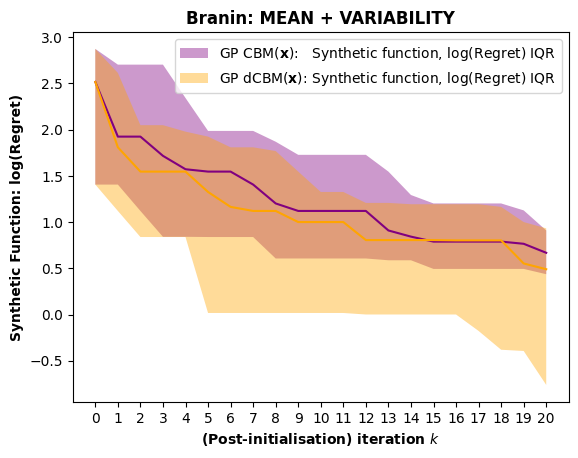

In [163]:
### Visualise!

erm_both = ': MEAN + VARIABILITY'
title = obj_func + erm_both

plt.figure()

plt.plot(median_approx, color = 'Purple')
plt.plot(median_exact, color = 'Orange')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Purple', alpha=0.4, label='GP CBM($\mathbf{x}$):   Synthetic function, log(Regret) IQR')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Orange', alpha=0.4, label='GP dCBM($\mathbf{x}$): Synthetic function, log(Regret) IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show()


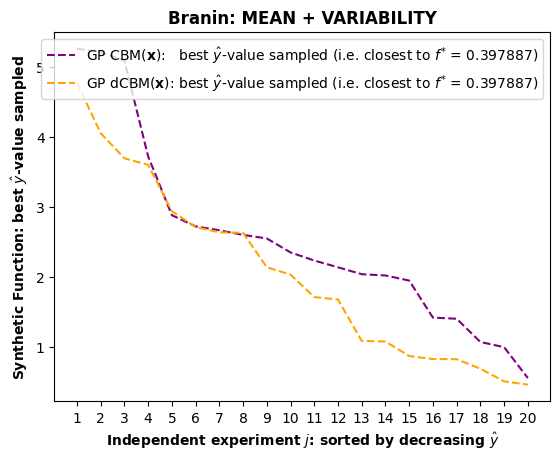

In [164]:
### Visualise!

cbm_both = ': MEAN + VARIABILITY'
title = obj_func + cbm_both

plt.figure()

plt.plot(np.sort(approx_tau)[::-1], color = 'Purple', ls='--', label='GP CBM($\mathbf{x}$):   best $\it{\hat{y}}$-value sampled (i.e. closest to $\it{f^{*}}$ = 0.397887)')
plt.plot(np.sort(exact_tau)[::-1], color = 'Orange', ls='--', label='GP dCBM($\mathbf{x}$): best $\it{\hat{y}}$-value sampled (i.e. closest to $\it{f^{*}}$ = 0.397887)')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$: sorted by decreasing $\it{\hat{y}}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: best $\it{\hat{y}}$-value sampled', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


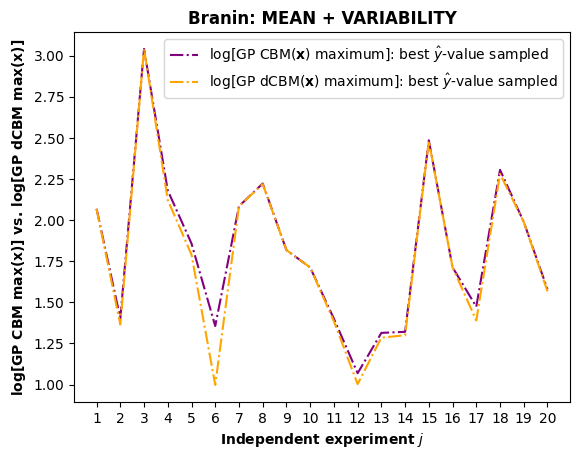

In [165]:
### Visualise!

cbm_both = ': MEAN + VARIABILITY'
title = obj_func + cbm_both

plt.figure()

plt.plot(np.log(exact_acqFuncApproxBest), color = 'Purple', ls='-.', label='log[GP CBM($\mathbf{x}$) maximum]: best $\it{\hat{y}}$-value sampled')
plt.plot(np.log(exact_acqFuncExactBest), color = 'Orange', ls='-.', label='log[GP dCBM($\mathbf{x}$) maximum]: best $\it{\hat{y}}$-value sampled')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('log[GP CBM max($\mathbf{x}$)] vs. log[GP dCBM max($\mathbf{x}$)]', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


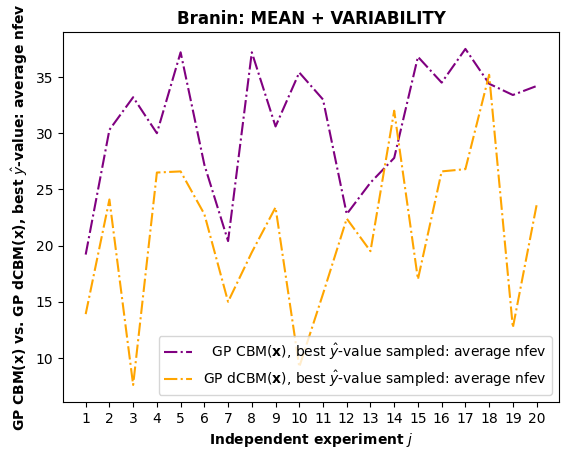

In [166]:
### Visualise!

cbm_both = ': MEAN + VARIABILITY'
title = obj_func + cbm_both

plt.figure()

plt.plot(approx_nfev_Avg, color = 'Purple', ls='-.', label='  GP CBM($\mathbf{x}$), best $\it{\hat{y}}$-value sampled: average nfev')
plt.plot(exact_nfev_Avg, color = 'Orange', ls='-.', label='GP dCBM($\mathbf{x}$), best $\it{\hat{y}}$-value sampled: average nfev')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP CBM($\mathbf{x}$) vs. GP dCBM($\mathbf{x}$), best $\it{\hat{y}}$-value: average nfev', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


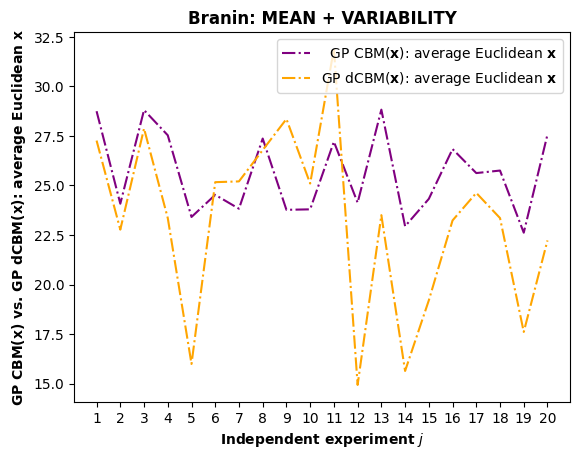

In [167]:
### Visualise!

cbm_both = ': MEAN + VARIABILITY'
title = obj_func + cbm_both

plt.figure()

plt.plot(approx_euclid_Avg, color = 'Purple', ls='-.', label='  GP CBM($\mathbf{x}$): average Euclidean $\mathbf{x}$')
plt.plot(exact_euclid_Avg, color = 'Orange', ls='-.', label='GP dCBM($\mathbf{x}$): average Euclidean $\mathbf{x}$')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP CBM($\mathbf{x}$) vs. GP dCBM($\mathbf{x}$): average Euclidean $\mathbf{x}$', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


In [168]:
np.round(-approx_4.f_best, 4), np.max(np.round(-approx_4.f_best, 4)), approx_4.best


(array([ 5.1069, -0.6905,  4.6364,  4.6364,  3.7535,  1.998 ,  1.998 ,
         5.1069,  4.1902,  3.1194,  4.6364,  4.9947,  5.1069,  4.1902,
         4.6364,  2.6011,  4.3382,  4.3382,  5.1069,  4.6364]),
 5.1069,
 array([1.45674781, 6.74007135]))

In [169]:
np.round(-approx_4.f_best2, 4), np.max(np.round(-approx_4.f_best2, 4)), approx_4.best2


(array([ 5.0115e+00, -4.5860e+00, -8.6210e-01,  4.5257e+00, -1.4000e-03,
        -1.0913e+01,  5.0858e+00,  4.7186e+00,  4.1186e+00,  2.3364e+00,
         4.6272e+00,  4.9453e+00,  4.9960e+00,  2.7940e+00,  4.3572e+00,
         4.3232e+00,  3.9859e+00,  6.9570e-01,  4.5781e+00,  4.2693e+00]),
 5.0858,
 array([1.31047111, 7.01938209]))

In [170]:
np.round(approx_4.x_best, 4)


array([[ 1.4567,  6.7401],
       [-3.5839,  2.6126],
       [ 1.839 , 10.4292],
       [ 1.839 , 10.4292],
       [-2.9044, 11.8252],
       [10.    ,  0.    ],
       [10.    ,  0.    ],
       [ 1.4567,  6.7401],
       [-2.9543,  7.8627],
       [ 3.4867, 15.    ],
       [ 1.839 , 10.4292],
       [ 3.4383,  1.4979],
       [ 1.4568,  6.7401],
       [-2.9543,  7.8627],
       [ 1.839 , 10.4292],
       [ 3.8979, 13.2743],
       [10.    ,  2.2178],
       [10.    ,  2.2178],
       [ 1.4567,  6.7401],
       [ 1.839 , 10.4292]])

In [171]:
np.round(approx_4.x_best2, 4)


array([[ 1.0678,  7.6606],
       [-4.7861,  2.6639],
       [ 3.4641, 10.2835],
       [ 1.9496, 10.2634],
       [-0.1706, 11.4908],
       [ 5.0265,  9.3217],
       [ 1.3105,  7.0194],
       [ 3.7263,  0.1199],
       [-2.8647,  7.7384],
       [ 3.6681, 14.5642],
       [ 1.7929, 10.4652],
       [ 3.6747,  1.0408],
       [ 1.0313,  7.7642],
       [-2.6486,  7.1296],
       [ 1.79  ,  9.9351],
       [ 1.0445,  8.9283],
       [10.    ,  3.0978],
       [ 8.8662,  6.3781],
       [ 2.5993,  2.4551],
       [ 1.4109,  9.416 ]])

In [172]:
np.sqrt(np.sum((approx_4.start_points_arr - approx_4.x_best)**2))


21.66546327236452

In [173]:
np.sqrt(np.sum((approx_4.start_points_arr - approx_4.x_best2)**2))

13.524760440837973